In [1]:
!pip install torch torchvision torchaudio
!pip install geoopt
!pip install networkx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 2.3 MB/s eta 0:00:00


## WORDNET and FB15k

This Chunk loads in Fb15k or Wordnet Dataset and defines the features

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from torch import optim
import geoopt
from geoopt import ManifoldParameter
import os
from tqdm import tqdm
import pandas as pd



#change here
dataset = 'fb15k' # replace with wordnet



##############################################
# Data Loading and Preprocessing
##############################################
def load_fb15k_data(train_path, valid_path, test_path):
    def read_triples(path, ent2id, rel2id):
        triples = []
        with open(path, 'r') as f:
            for line in f:
                h, r, t = line.strip().split('\t')
                if h not in ent2id:
                    ent2id[h] = len(ent2id)
                if t not in ent2id:
                    ent2id[t] = len(ent2id)
                if r not in rel2id:
                    rel2id[r] = len(rel2id)
                triples.append((ent2id[h], rel2id[r], ent2id[t]))
        return triples

    ent2id = {}
    rel2id = {}
    train_triples = read_triples(train_path, ent2id, rel2id)
    valid_triples = read_triples(valid_path, ent2id, rel2id)
    test_triples = read_triples(test_path, ent2id, rel2id)

    G = nx.Graph()
    G.add_nodes_from(range(len(ent2id)))
    for h, r, t in train_triples:
        G.add_edge(h, t)

    return ent2id, rel2id, G, train_triples, valid_triples, test_triples

def load_wordnet_data(train_path, valid_path, test_path):
    def read_triples(path, ent2id, rel2id):
        triples = []
        df = pd.read_csv(path, header=None, names=["head", "relation", "tail"])
        for _, row in df.iterrows():
            h, r, t = row["head"], row["relation"], row["tail"]
            if h not in ent2id:
                ent2id[h] = len(ent2id)
            if t not in ent2id:
                ent2id[t] = len(ent2id)
            if r not in rel2id:
                rel2id[r] = len(rel2id)
            triples.append((ent2id[h], rel2id[r], ent2id[t]))
        return triples

    ent2id = {}
    rel2id = {}
    train_triples = read_triples(train_path, ent2id, rel2id)
    valid_triples = read_triples(valid_path, ent2id, rel2id)
    test_triples = read_triples(test_path, ent2id, rel2id)

    G = nx.Graph()
    G.add_nodes_from(range(len(ent2id)))
    for h, r, t in train_triples:
        G.add_edge(h, t)

    return ent2id, rel2id, G, train_triples, valid_triples, test_triples





# Load data
if dataset == 'fb15k':
    train_path = 'FB15k_train.txt'
    valid_path = 'FB15k_valid.txt'
    test_path = 'FB15k_test.txt'
    ent2id, rel2id, G, train_triples, valid_triples, test_triples = load_fb15k_data(train_path, valid_path, test_path) # fb15k

elif dataset == 'wordnet':
    train_path = 'wordnet_train.csv'
    valid_path = 'wordnet_valid.csv'
    test_path = 'wordnet_test.csv'
    ent2id, rel2id, G, train_triples, valid_triples, test_triples = load_wordnet_data(train_path, valid_path, test_path) # wordnet


num_entities = len(ent2id)
num_relations = len(rel2id)

print(f"Number of Entities: {num_entities}")
print(f"Number of Relations: {num_relations}")
print(f"Number of Training Triples: {len(train_triples)}")
print(f"Number of Validation Triples: {len(valid_triples)}")
print(f"Number of Test Triples: {len(test_triples)}")

from scipy.sparse import csr_matrix, diags
import numpy as np

# Convert adjacency matrix to a sparse matrix
adj = nx.to_scipy_sparse_array(G, nodelist=range(num_entities)).tocsc()

# Add self-loops
adj += diags([1e-5] * num_entities)

# Compute degree
degrees = np.array(adj.sum(axis=1)).flatten()

# Compute D^-0.5 (inverse square root of degree matrix)
inv_sqrt_deg = np.power(degrees, -0.5)
inv_sqrt_deg[np.isinf(inv_sqrt_deg)] = 0
D_inv_sqrt = diags(inv_sqrt_deg)

# Normalize adjacency matrix: D^-0.5 * A * D^-0.5
norm_adj = D_inv_sqrt @ adj @ D_inv_sqrt

# Convert back to a PyTorch tensor
# To save memory, keep it on CPU if possible or use sparse tensors
norm_adj = torch.tensor(norm_adj.toarray(), dtype=torch.float32)  # If GPU is available, use .to(device)

# Node Features: Use lower-dimensional learnable embeddings instead of one-hot
embedding_dim = 128  # Reduced dimensionality
# Initialize features as learnable parameters
features = nn.Parameter(torch.randn(num_entities, embedding_dim), requires_grad=False)  # Initialize on CPU

# Move tensors to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features, norm_adj = features.to(device), norm_adj.to(device)

print(f"Using device: {device}")


Number of Entities: 14541
Number of Relations: 237
Number of Training Triples: 272115
Number of Validation Triples: 17535
Number of Test Triples: 20466
Using device: cuda


This Chunk defines the HGCN and the Link Prediction Task and provides data loading training and evaluation functions

In [3]:
##############################################
# Hyperbolic GCN and Link Prediction Model
##############################################

class HyperbolicLinear(nn.Module):
    """
    Hyperbolic linear layer using the Poincaré Ball model.
    """
    def __init__(self, manifold, in_features, out_features, bias=True):
        super(HyperbolicLinear, self).__init__()
        self.manifold = manifold
        self.in_features = in_features
        self.out_features = out_features
        # ManifoldParameter for weight in Euclidean space
        self.weight = ManifoldParameter(torch.randn(out_features, in_features) * 0.01, manifold=geoopt.Euclidean())
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        # x is on manifold. Map to tangent space at 0, apply linear, map back
        x_tan = self.manifold.logmap0(x, dim=-1)
        out = F.linear(x_tan, self.weight, self.bias)
        out = self.manifold.expmap0(out, dim=-1)
        return out

class HyperbolicGCNLayer(nn.Module):
    def __init__(self, manifold, in_features, out_features):
        super(HyperbolicGCNLayer, self).__init__()
        self.manifold = manifold
        self.lin = HyperbolicLinear(manifold, in_features, out_features)

    def forward(self, x, adj):
        # x on manifold
        x_tan = self.manifold.logmap0(x, dim=-1)
        x_agg_tan = adj @ x_tan  # Aggregate in tangent space
        x_agg = self.manifold.expmap0(x_agg_tan, dim=-1)
        return self.lin(x_agg)




############################################################################################


class HyperbolicGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, c=1.0):
        super(HyperbolicGCN, self).__init__()
        # Initialize the manifold inside the model to ensure its parameters are included
        self.manifold = geoopt.PoincareBall(c=c, learnable=True)
        self.layer1 = HyperbolicGCNLayer(self.manifold, num_features, hidden_dim)
        self.layer2 = HyperbolicGCNLayer(self.manifold, hidden_dim, hidden_dim)

    def forward(self, x, adj):
        x = self.manifold.expmap0(x, dim=-1)  # Ensure x is on manifold
        x = self.layer1(x, adj)
        # Hyperbolic activation: apply tanh in tangent space
        x_tan = self.manifold.logmap0(x, dim=-1)
        x_tan = torch.tanh(x_tan)
        x = self.manifold.expmap0(x_tan, dim=-1)
        x = self.layer2(x, adj)
        return x

from geoopt.manifolds import PoincareBall

class LinkPredictionModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_relations, c=1.0):
        super(LinkPredictionModel, self).__init__()
        self.manifold = PoincareBall(c=c)
        self.node_emb = geoopt.ManifoldParameter(
            self.manifold.random((num_features, hidden_dim), std=1e-2),
            manifold=self.manifold
        )
        self.gcn = HyperbolicGCN(num_features, hidden_dim, c=c)
        self.classifier = nn.Linear(hidden_dim * 2, num_relations)
        nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, x, adj):
        node_emb = self.gcn(x, adj)  # [num_nodes, hidden_dim]
        return node_emb

    def classify(self, head_idx, tail_idx, node_emb):
        # Retrieve embeddings
        head_emb = node_emb[head_idx]     # [batch_size, hidden_dim]
        tail_emb = node_emb[tail_idx]     # [batch_size, hidden_dim]
        # Concatenate head and tail embeddings
        combined = torch.cat([head_emb, tail_emb], dim=1)  # [batch_size, hidden_dim * 2]
        scores = self.classifier(combined)  # [batch_size, num_relations]
        return scores

##############################################
# Training and Evaluation Utilities
##############################################

def prepare_data(triples):
    """
    Prepare tensors for head, tail, and relation indices.
    """
    triples = torch.tensor(triples, dtype=torch.long, device=device)
    heads = triples[:, 0]
    relations = triples[:, 1]
    tails = triples[:, 2]
    return heads, tails, relations

def train_epoch(model, optimizer, criterion, heads, tails, relations, node_emb):
    model.train()
    optimizer.zero_grad()

    # Get relation scores
    scores = model.classify(heads, tails, node_emb)  # [batch_size, num_relations]

    # Compute loss
    loss = criterion(scores, relations)
    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate(model, criterion, heads, tails, relations, node_emb):
    model.eval()
    with torch.no_grad():
        scores = model.classify(heads, tails, node_emb)  # [batch_size, num_relations]
        loss = criterion(scores, relations).item()
        preds = torch.argmax(scores, dim=1)
        correct = (preds == relations).sum().item()
        total = relations.size(0)
        accuracy = correct / total
    return loss, accuracy

This chunk defines optimizers we use

In [4]:
# OPTIMIZER CODING

# Riemannian Adagrad
import torch
from torch.optim import Optimizer

class RiemannianAdagrad(Optimizer):
    def __init__(self, params, lr=1e-2, eps=1e-10, weight_decay=0):
        defaults = dict(lr=lr, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('RiemannianAdagrad does not support sparse gradients')

                # Retrieve manifold
                manifold = getattr(p, "manifold", None)
                if manifold is None:
                    raise RuntimeError("Parameter does not have a manifold defined")

                # Initialize state
                state = self.state[p]
                if "sum_sq" not in state:
                    state["sum_sq"] = torch.zeros_like(p.data)

                sum_sq = state["sum_sq"]

                # Update sum of squared gradients
                sum_sq.addcmul_(grad, grad, value=1)

                # Apply weight decay if necessary
                if group["weight_decay"] != 0:
                    grad = grad.add(p.data, alpha=group["weight_decay"])

                # Compute update
                update = grad / (sum_sq.sqrt().add(group["eps"]))

                # Riemannian update
                update = -group["lr"] * update
                p.data = manifold.proj(manifold.expmap(update, p.data))

        return loss

# Mixed-precision Riemannian optimizer
from torch.cuda.amp import GradScaler

scaler = GradScaler()

class MixedPrecisionRiemannianAdam(geoopt.optim.RiemannianAdam):
    def step(self, closure=None):
        """
        Override step to use gradient scaling for mixed precision.
        """
        if closure is not None:
            loss = closure()
        else:
            loss = None

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    # Scale the gradient back to normal scale
                    p.grad.data = scaler.scale(p.grad.data)

        super().step(closure)
        return loss

<ipython-input-4-c9d070ff581b>:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


This Chunk is the training loop and where we choose starting curvature, learning rates, and the optimizer used

In [7]:
################ criterion = nn.CrossEntropyLoss(), Multiclass #################################
# SET OPTIMIZER, LEARNING RATE, and C INITIAL VALUE

##############################################
# Training Loop
##############################################

# Initialize the model
hidden_dim = 128  # Reduced hidden dimension
model = LinkPredictionModel(num_features=embedding_dim, hidden_dim=hidden_dim, num_relations=num_relations, c=1.0).to(device) # edit starting curvature

with torch.no_grad():
    x = model.gcn.manifold.expmap0(features, dim=-1)

# Optimizer Choices and learning rates:
riemannian_adam = geoopt.optim.RiemannianAdam(model.parameters(), lr=1e-3) # we changed all of these learning rates a lot during experimentation
riemannian_sgd = geoopt.optim.RiemannianSGD(model.parameters(), lr=1e-1)
riemannian_mixed_precision = MixedPrecisionRiemannianAdam(model.parameters(), lr=1e-1)
riemannian_adagrad = RiemannianAdagrad(model.parameters(), lr=1e-2) # error currently

# SET OPTIMIZER:
optimizer = riemannian_adam

# Define loss function for multi-class link prediction
criterion = nn.CrossEntropyLoss()

# Prepare training, validation, and test data
train_heads, train_tails, train_relations = prepare_data(train_triples)
valid_heads, valid_tails, valid_relations = prepare_data(valid_triples)
test_heads, test_tails, test_relations = prepare_data(test_triples)

num_epochs = 1500
best_val_accuracy = 0.0
best_test_accuracy = 0.0

curvatures, train_losses, val_losses, val_accuracies, test_accuracies = [], [], [], [], []

print("\nStarting Training...\n")
for epoch in tqdm(range(1, num_epochs + 1)):
    # Forward pass to get node embeddings
    node_emb = model(features, norm_adj)  # [num_nodes, hidden_dim]

    # Training
    train_loss = train_epoch(model, optimizer, criterion, train_heads, train_tails, train_relations, node_emb)

    # Evaluation on Validation Set
    val_loss, val_accuracy = evaluate(model, criterion, valid_heads, valid_tails, valid_relations, node_emb)

    # Early Stopping and Best Model Tracking
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Evaluate on Test Set
        test_loss, test_accuracy = evaluate(model, criterion, test_heads, test_tails, test_relations, node_emb)
        best_test_accuracy = test_accuracy


    # Print Epoch Results
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}, Best Test Acc={best_test_accuracy:.4f}, Curvature: {model.gcn.manifold.c.item():.6f}")

    curvatures.append(model.gcn.manifold.c.item())
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

print("\nTraining Completed.")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Corresponding Test Accuracy: {best_test_accuracy:.4f}")
print(f"Curvature: {model.gcn.manifold.c.item():.6f}")

##############################################
# Inference and Evaluation
##############################################

def predict_relation(model, head_idx, tail_idx, node_emb):
    model.eval()
    with torch.no_grad():
        scores = model.classify(head_idx, tail_idx, node_emb)  # [batch_size, num_relations]
        predicted_relations = torch.argmax(scores, dim=1)
    return predicted_relations

def evaluate_full(model, criterion, heads, tails, relations, node_emb):
    model.eval()
    with torch.no_grad():
        scores = model.classify(heads, tails, node_emb)  # [batch_size, num_relations]
        loss = criterion(scores, relations).item()
        preds = torch.argmax(scores, dim=1)
        correct = (preds == relations).sum().item()
        total = relations.size(0)
        accuracy = correct / total
    return loss, accuracy

# Example Inference
sample_head = train_triples[0][0]
sample_tail = train_triples[0][2]
sample_relation = train_triples[0][1]

predicted_relation = predict_relation(model, torch.tensor([sample_head], device=device),
                                      torch.tensor([sample_tail], device=device),
                                      node_emb)

print("\nSample Inference:")
print(f"Head Entity ID: {sample_head}, Tail Entity ID: {sample_tail}")
print(f"Actual Relation ID: {sample_relation}, Predicted Relation ID: {predicted_relation.item()}")


Starting Training...



  0%|          | 2/1500 [00:00<01:35, 15.73it/s]

Epoch 001: Train Loss=5.4777, Val Loss=5.4738, Val Acc=0.0029, Best Test Acc=0.0026, Curvature: 0.999371


  1%|          | 12/1500 [00:00<01:21, 18.25it/s]

Epoch 010: Train Loss=5.3911, Val Loss=5.3725, Val Acc=0.0215, Best Test Acc=0.0239, Curvature: 0.994557


  1%|▏         | 22/1500 [00:01<01:19, 18.67it/s]

Epoch 020: Train Loss=5.1502, Val Loss=5.1157, Val Acc=0.0505, Best Test Acc=0.0529, Curvature: 0.988240


  2%|▏         | 32/1500 [00:01<01:17, 18.91it/s]

Epoch 030: Train Loss=4.8920, Val Loss=4.8648, Val Acc=0.0472, Best Test Acc=0.1121, Curvature: 0.980626


  3%|▎         | 42/1500 [00:02<01:17, 18.79it/s]

Epoch 040: Train Loss=4.7273, Val Loss=4.7164, Val Acc=0.0472, Best Test Acc=0.1121, Curvature: 0.972273


  3%|▎         | 52/1500 [00:02<01:15, 19.10it/s]

Epoch 050: Train Loss=4.6292, Val Loss=4.6362, Val Acc=0.0472, Best Test Acc=0.1121, Curvature: 0.963955


  4%|▍         | 62/1500 [00:03<01:14, 19.21it/s]

Epoch 060: Train Loss=4.5710, Val Loss=4.5884, Val Acc=0.0472, Best Test Acc=0.1121, Curvature: 0.956280


  5%|▍         | 72/1500 [00:03<01:14, 19.12it/s]

Epoch 070: Train Loss=4.5317, Val Loss=4.5514, Val Acc=0.0110, Best Test Acc=0.1121, Curvature: 0.949524


  5%|▌         | 82/1500 [00:04<01:14, 19.11it/s]

Epoch 080: Train Loss=4.4968, Val Loss=4.5193, Val Acc=0.0167, Best Test Acc=0.1121, Curvature: 0.943581


  6%|▌         | 92/1500 [00:04<01:13, 19.11it/s]

Epoch 090: Train Loss=4.4498, Val Loss=4.4800, Val Acc=0.0171, Best Test Acc=0.1121, Curvature: 0.937908


  7%|▋         | 102/1500 [00:05<01:13, 19.09it/s]

Epoch 100: Train Loss=4.3834, Val Loss=4.4234, Val Acc=0.0182, Best Test Acc=0.1121, Curvature: 0.931791


  7%|▋         | 112/1500 [00:05<01:13, 19.01it/s]

Epoch 110: Train Loss=4.3044, Val Loss=4.3493, Val Acc=0.0688, Best Test Acc=0.1121, Curvature: 0.924821


  8%|▊         | 122/1500 [00:06<01:12, 19.01it/s]

Epoch 120: Train Loss=4.2135, Val Loss=4.2650, Val Acc=0.0853, Best Test Acc=0.1121, Curvature: 0.917126


  9%|▉         | 132/1500 [00:06<01:12, 18.92it/s]

Epoch 130: Train Loss=4.1079, Val Loss=4.1664, Val Acc=0.0989, Best Test Acc=0.1121, Curvature: 0.908890


  9%|▉         | 142/1500 [00:07<01:12, 18.81it/s]

Epoch 140: Train Loss=3.9938, Val Loss=4.0570, Val Acc=0.1280, Best Test Acc=0.1266, Curvature: 0.900146


 10%|█         | 152/1500 [00:08<01:11, 18.76it/s]

Epoch 150: Train Loss=3.8788, Val Loss=3.9461, Val Acc=0.1544, Best Test Acc=0.1548, Curvature: 0.890991


 11%|█         | 162/1500 [00:08<01:11, 18.68it/s]

Epoch 160: Train Loss=3.7684, Val Loss=3.8377, Val Acc=0.1796, Best Test Acc=0.1841, Curvature: 0.881614


 11%|█▏        | 172/1500 [00:09<01:10, 18.72it/s]

Epoch 170: Train Loss=3.6638, Val Loss=3.7343, Val Acc=0.2042, Best Test Acc=0.2106, Curvature: 0.872177


 12%|█▏        | 182/1500 [00:09<01:10, 18.76it/s]

Epoch 180: Train Loss=3.5646, Val Loss=3.6369, Val Acc=0.2285, Best Test Acc=0.2318, Curvature: 0.862775


 13%|█▎        | 192/1500 [00:10<01:09, 18.78it/s]

Epoch 190: Train Loss=3.4696, Val Loss=3.5430, Val Acc=0.2591, Best Test Acc=0.2636, Curvature: 0.853465


 13%|█▎        | 202/1500 [00:10<01:09, 18.75it/s]

Epoch 200: Train Loss=3.3773, Val Loss=3.4502, Val Acc=0.2880, Best Test Acc=0.2903, Curvature: 0.844273


 14%|█▍        | 212/1500 [00:11<01:08, 18.68it/s]

Epoch 210: Train Loss=3.2872, Val Loss=3.3573, Val Acc=0.3096, Best Test Acc=0.3108, Curvature: 0.835207


 15%|█▍        | 222/1500 [00:11<01:08, 18.62it/s]

Epoch 220: Train Loss=3.1989, Val Loss=3.2650, Val Acc=0.3268, Best Test Acc=0.3280, Curvature: 0.826268


 15%|█▌        | 232/1500 [00:12<01:07, 18.69it/s]

Epoch 230: Train Loss=3.1128, Val Loss=3.1738, Val Acc=0.3434, Best Test Acc=0.3433, Curvature: 0.817464


 16%|█▌        | 242/1500 [00:12<01:07, 18.74it/s]

Epoch 240: Train Loss=3.0287, Val Loss=3.0840, Val Acc=0.3574, Best Test Acc=0.3564, Curvature: 0.808802


 17%|█▋        | 252/1500 [00:13<01:06, 18.83it/s]

Epoch 250: Train Loss=2.9467, Val Loss=2.9963, Val Acc=0.3696, Best Test Acc=0.3712, Curvature: 0.800285


 17%|█▋        | 262/1500 [00:13<01:05, 18.80it/s]

Epoch 260: Train Loss=2.8667, Val Loss=2.9111, Val Acc=0.3825, Best Test Acc=0.3836, Curvature: 0.791911


 18%|█▊        | 272/1500 [00:14<01:05, 18.81it/s]

Epoch 270: Train Loss=2.7892, Val Loss=2.8287, Val Acc=0.3933, Best Test Acc=0.3965, Curvature: 0.783681


 19%|█▉        | 282/1500 [00:14<01:04, 18.78it/s]

Epoch 280: Train Loss=2.7150, Val Loss=2.7501, Val Acc=0.4056, Best Test Acc=0.4102, Curvature: 0.775600


 19%|█▉        | 292/1500 [00:15<01:04, 18.72it/s]

Epoch 290: Train Loss=2.6446, Val Loss=2.6758, Val Acc=0.4220, Best Test Acc=0.4251, Curvature: 0.767681


 20%|██        | 302/1500 [00:16<01:03, 18.76it/s]

Epoch 300: Train Loss=2.5783, Val Loss=2.6060, Val Acc=0.4364, Best Test Acc=0.4414, Curvature: 0.759938


 21%|██        | 312/1500 [00:16<01:03, 18.76it/s]

Epoch 310: Train Loss=2.5162, Val Loss=2.5409, Val Acc=0.4475, Best Test Acc=0.4531, Curvature: 0.752385


 21%|██▏       | 322/1500 [00:17<01:02, 18.80it/s]

Epoch 320: Train Loss=2.4581, Val Loss=2.4803, Val Acc=0.4570, Best Test Acc=0.4634, Curvature: 0.745028


 22%|██▏       | 332/1500 [00:17<01:02, 18.77it/s]

Epoch 330: Train Loss=2.4039, Val Loss=2.4237, Val Acc=0.4658, Best Test Acc=0.4715, Curvature: 0.737869


 23%|██▎       | 342/1500 [00:18<01:01, 18.74it/s]

Epoch 340: Train Loss=2.3532, Val Loss=2.3707, Val Acc=0.4741, Best Test Acc=0.4784, Curvature: 0.730905


 23%|██▎       | 352/1500 [00:18<01:01, 18.69it/s]

Epoch 350: Train Loss=2.3056, Val Loss=2.3208, Val Acc=0.4821, Best Test Acc=0.4854, Curvature: 0.724128


 24%|██▍       | 362/1500 [00:19<01:00, 18.69it/s]

Epoch 360: Train Loss=2.2608, Val Loss=2.2735, Val Acc=0.4902, Best Test Acc=0.4921, Curvature: 0.717529


 25%|██▍       | 372/1500 [00:19<01:00, 18.75it/s]

Epoch 370: Train Loss=2.2184, Val Loss=2.2283, Val Acc=0.4968, Best Test Acc=0.4984, Curvature: 0.711097


 25%|██▌       | 382/1500 [00:20<00:59, 18.76it/s]

Epoch 380: Train Loss=2.1780, Val Loss=2.1851, Val Acc=0.5042, Best Test Acc=0.5053, Curvature: 0.704820


 26%|██▌       | 392/1500 [00:20<00:58, 18.83it/s]

Epoch 390: Train Loss=2.1395, Val Loss=2.1436, Val Acc=0.5129, Best Test Acc=0.5107, Curvature: 0.698688


 27%|██▋       | 402/1500 [00:21<00:58, 18.83it/s]

Epoch 400: Train Loss=2.1026, Val Loss=2.1034, Val Acc=0.5200, Best Test Acc=0.5188, Curvature: 0.692689


 27%|██▋       | 412/1500 [00:21<00:57, 18.84it/s]

Epoch 410: Train Loss=2.0670, Val Loss=2.0644, Val Acc=0.5266, Best Test Acc=0.5265, Curvature: 0.686814


 28%|██▊       | 422/1500 [00:22<00:57, 18.82it/s]

Epoch 420: Train Loss=2.0326, Val Loss=2.0264, Val Acc=0.5343, Best Test Acc=0.5332, Curvature: 0.681052


 29%|██▉       | 432/1500 [00:22<00:56, 18.79it/s]

Epoch 430: Train Loss=1.9992, Val Loss=1.9893, Val Acc=0.5434, Best Test Acc=0.5423, Curvature: 0.675394


 29%|██▉       | 442/1500 [00:23<00:56, 18.82it/s]

Epoch 440: Train Loss=1.9667, Val Loss=1.9530, Val Acc=0.5518, Best Test Acc=0.5503, Curvature: 0.669831


 30%|███       | 452/1500 [00:24<00:55, 18.74it/s]

Epoch 450: Train Loss=1.9350, Val Loss=1.9173, Val Acc=0.5596, Best Test Acc=0.5596, Curvature: 0.664356


 31%|███       | 462/1500 [00:24<00:55, 18.75it/s]

Epoch 460: Train Loss=1.9040, Val Loss=1.8823, Val Acc=0.5685, Best Test Acc=0.5683, Curvature: 0.658961


 31%|███▏      | 472/1500 [00:25<00:54, 18.81it/s]

Epoch 470: Train Loss=1.8737, Val Loss=1.8479, Val Acc=0.5780, Best Test Acc=0.5749, Curvature: 0.653642


 32%|███▏      | 482/1500 [00:25<00:53, 18.89it/s]

Epoch 480: Train Loss=1.8441, Val Loss=1.8141, Val Acc=0.5849, Best Test Acc=0.5823, Curvature: 0.648393


 33%|███▎      | 492/1500 [00:26<00:53, 18.90it/s]

Epoch 490: Train Loss=1.8151, Val Loss=1.7809, Val Acc=0.5921, Best Test Acc=0.5901, Curvature: 0.643211


 33%|███▎      | 502/1500 [00:26<00:53, 18.74it/s]

Epoch 500: Train Loss=1.7868, Val Loss=1.7483, Val Acc=0.6003, Best Test Acc=0.5978, Curvature: 0.638093


 34%|███▍      | 512/1500 [00:27<00:52, 18.78it/s]

Epoch 510: Train Loss=1.7592, Val Loss=1.7165, Val Acc=0.6070, Best Test Acc=0.6055, Curvature: 0.633040


 35%|███▍      | 522/1500 [00:27<00:52, 18.74it/s]

Epoch 520: Train Loss=1.7324, Val Loss=1.6854, Val Acc=0.6136, Best Test Acc=0.6115, Curvature: 0.628049


 35%|███▌      | 532/1500 [00:28<00:51, 18.83it/s]

Epoch 530: Train Loss=1.7063, Val Loss=1.6551, Val Acc=0.6204, Best Test Acc=0.6170, Curvature: 0.623122


 36%|███▌      | 542/1500 [00:28<00:50, 18.82it/s]

Epoch 540: Train Loss=1.6810, Val Loss=1.6256, Val Acc=0.6267, Best Test Acc=0.6233, Curvature: 0.618258


 37%|███▋      | 552/1500 [00:29<00:50, 18.76it/s]

Epoch 550: Train Loss=1.6565, Val Loss=1.5969, Val Acc=0.6318, Best Test Acc=0.6290, Curvature: 0.613460


 37%|███▋      | 562/1500 [00:29<00:49, 18.84it/s]

Epoch 560: Train Loss=1.6328, Val Loss=1.5692, Val Acc=0.6393, Best Test Acc=0.6357, Curvature: 0.608729


 38%|███▊      | 572/1500 [00:30<00:49, 18.76it/s]

Epoch 570: Train Loss=1.6099, Val Loss=1.5423, Val Acc=0.6457, Best Test Acc=0.6430, Curvature: 0.604067


 39%|███▉      | 582/1500 [00:30<00:49, 18.72it/s]

Epoch 580: Train Loss=1.5878, Val Loss=1.5163, Val Acc=0.6505, Best Test Acc=0.6492, Curvature: 0.599473


 39%|███▉      | 592/1500 [00:31<00:48, 18.80it/s]

Epoch 590: Train Loss=1.5665, Val Loss=1.4912, Val Acc=0.6575, Best Test Acc=0.6563, Curvature: 0.594949


 40%|████      | 602/1500 [00:32<00:47, 18.82it/s]

Epoch 600: Train Loss=1.5459, Val Loss=1.4669, Val Acc=0.6638, Best Test Acc=0.6631, Curvature: 0.590494


 41%|████      | 612/1500 [00:32<00:47, 18.81it/s]

Epoch 610: Train Loss=1.5260, Val Loss=1.4435, Val Acc=0.6707, Best Test Acc=0.6692, Curvature: 0.586108


 41%|████▏     | 622/1500 [00:33<00:46, 18.82it/s]

Epoch 620: Train Loss=1.5068, Val Loss=1.4208, Val Acc=0.6772, Best Test Acc=0.6759, Curvature: 0.581789


 42%|████▏     | 632/1500 [00:33<00:46, 18.85it/s]

Epoch 630: Train Loss=1.4883, Val Loss=1.3990, Val Acc=0.6843, Best Test Acc=0.6812, Curvature: 0.577536


 43%|████▎     | 642/1500 [00:34<00:45, 18.86it/s]

Epoch 640: Train Loss=1.4704, Val Loss=1.3779, Val Acc=0.6895, Best Test Acc=0.6861, Curvature: 0.573348


 43%|████▎     | 652/1500 [00:34<00:44, 18.89it/s]

Epoch 650: Train Loss=1.4531, Val Loss=1.3576, Val Acc=0.6947, Best Test Acc=0.6906, Curvature: 0.569223


 44%|████▍     | 662/1500 [00:35<00:44, 18.80it/s]

Epoch 660: Train Loss=1.4365, Val Loss=1.3379, Val Acc=0.6987, Best Test Acc=0.6952, Curvature: 0.565161


 45%|████▍     | 672/1500 [00:35<00:44, 18.79it/s]

Epoch 670: Train Loss=1.4204, Val Loss=1.3190, Val Acc=0.7029, Best Test Acc=0.6995, Curvature: 0.561162


 45%|████▌     | 682/1500 [00:36<00:43, 18.83it/s]

Epoch 680: Train Loss=1.4048, Val Loss=1.3006, Val Acc=0.7069, Best Test Acc=0.7038, Curvature: 0.557222


 46%|████▌     | 692/1500 [00:36<00:42, 18.80it/s]

Epoch 690: Train Loss=1.3898, Val Loss=1.2829, Val Acc=0.7106, Best Test Acc=0.7075, Curvature: 0.553342


 47%|████▋     | 702/1500 [00:37<00:42, 18.85it/s]

Epoch 700: Train Loss=1.3752, Val Loss=1.2658, Val Acc=0.7147, Best Test Acc=0.7114, Curvature: 0.549520


 47%|████▋     | 712/1500 [00:37<00:41, 18.79it/s]

Epoch 710: Train Loss=1.3611, Val Loss=1.2492, Val Acc=0.7190, Best Test Acc=0.7160, Curvature: 0.545755


 48%|████▊     | 722/1500 [00:38<00:41, 18.84it/s]

Epoch 720: Train Loss=1.3475, Val Loss=1.2333, Val Acc=0.7218, Best Test Acc=0.7196, Curvature: 0.542045


 49%|████▉     | 732/1500 [00:38<00:41, 18.69it/s]

Epoch 730: Train Loss=1.3343, Val Loss=1.2178, Val Acc=0.7253, Best Test Acc=0.7232, Curvature: 0.538389


 49%|████▉     | 742/1500 [00:39<00:40, 18.80it/s]

Epoch 740: Train Loss=1.3215, Val Loss=1.2028, Val Acc=0.7293, Best Test Acc=0.7271, Curvature: 0.534786


 50%|█████     | 752/1500 [00:39<00:39, 18.76it/s]

Epoch 750: Train Loss=1.3091, Val Loss=1.1883, Val Acc=0.7331, Best Test Acc=0.7300, Curvature: 0.531234


 51%|█████     | 762/1500 [00:40<00:39, 18.74it/s]

Epoch 760: Train Loss=1.2970, Val Loss=1.1742, Val Acc=0.7371, Best Test Acc=0.7338, Curvature: 0.527732


 51%|█████▏    | 772/1500 [00:41<00:38, 18.74it/s]

Epoch 770: Train Loss=1.2854, Val Loss=1.1606, Val Acc=0.7398, Best Test Acc=0.7363, Curvature: 0.524279


 52%|█████▏    | 782/1500 [00:41<00:38, 18.80it/s]

Epoch 780: Train Loss=1.2740, Val Loss=1.1474, Val Acc=0.7431, Best Test Acc=0.7389, Curvature: 0.520873


 53%|█████▎    | 792/1500 [00:42<00:37, 18.69it/s]

Epoch 790: Train Loss=1.2630, Val Loss=1.1345, Val Acc=0.7458, Best Test Acc=0.7413, Curvature: 0.517514


 53%|█████▎    | 802/1500 [00:42<00:37, 18.71it/s]

Epoch 800: Train Loss=1.2522, Val Loss=1.1221, Val Acc=0.7480, Best Test Acc=0.7430, Curvature: 0.514198


 54%|█████▍    | 812/1500 [00:43<00:36, 18.85it/s]

Epoch 810: Train Loss=1.2418, Val Loss=1.1100, Val Acc=0.7503, Best Test Acc=0.7446, Curvature: 0.510926


 55%|█████▍    | 822/1500 [00:43<00:36, 18.83it/s]

Epoch 820: Train Loss=1.2316, Val Loss=1.0982, Val Acc=0.7527, Best Test Acc=0.7468, Curvature: 0.507696


 55%|█████▌    | 832/1500 [00:44<00:35, 18.82it/s]

Epoch 830: Train Loss=1.2217, Val Loss=1.0868, Val Acc=0.7544, Best Test Acc=0.7483, Curvature: 0.504507


 56%|█████▌    | 842/1500 [00:44<00:34, 18.80it/s]

Epoch 840: Train Loss=1.2121, Val Loss=1.0756, Val Acc=0.7566, Best Test Acc=0.7499, Curvature: 0.501358


 57%|█████▋    | 852/1500 [00:45<00:34, 18.76it/s]

Epoch 850: Train Loss=1.2026, Val Loss=1.0647, Val Acc=0.7587, Best Test Acc=0.7515, Curvature: 0.498248


 57%|█████▋    | 862/1500 [00:45<00:33, 18.83it/s]

Epoch 860: Train Loss=1.1934, Val Loss=1.0540, Val Acc=0.7591, Best Test Acc=0.7530, Curvature: 0.495177


 58%|█████▊    | 872/1500 [00:46<00:33, 18.79it/s]

Epoch 870: Train Loss=1.1843, Val Loss=1.0435, Val Acc=0.7605, Best Test Acc=0.7550, Curvature: 0.492148


 59%|█████▉    | 882/1500 [00:46<00:32, 18.82it/s]

Epoch 880: Train Loss=1.1754, Val Loss=1.0333, Val Acc=0.7622, Best Test Acc=0.7565, Curvature: 0.489156


 59%|█████▉    | 892/1500 [00:47<00:32, 18.77it/s]

Epoch 890: Train Loss=1.1667, Val Loss=1.0233, Val Acc=0.7629, Best Test Acc=0.7585, Curvature: 0.486199


 60%|██████    | 902/1500 [00:47<00:32, 18.65it/s]

Epoch 900: Train Loss=1.1581, Val Loss=1.0135, Val Acc=0.7654, Best Test Acc=0.7604, Curvature: 0.483275


 61%|██████    | 912/1500 [00:48<00:32, 18.05it/s]

Epoch 910: Train Loss=1.1497, Val Loss=1.0038, Val Acc=0.7669, Best Test Acc=0.7619, Curvature: 0.480382


 61%|██████▏   | 922/1500 [00:49<00:30, 18.67it/s]

Epoch 920: Train Loss=1.1415, Val Loss=0.9944, Val Acc=0.7687, Best Test Acc=0.7636, Curvature: 0.477519


 62%|██████▏   | 932/1500 [00:49<00:30, 18.74it/s]

Epoch 930: Train Loss=1.1334, Val Loss=0.9851, Val Acc=0.7706, Best Test Acc=0.7654, Curvature: 0.474685


 63%|██████▎   | 942/1500 [00:50<00:29, 18.76it/s]

Epoch 940: Train Loss=1.1254, Val Loss=0.9760, Val Acc=0.7725, Best Test Acc=0.7670, Curvature: 0.471879


 63%|██████▎   | 952/1500 [00:50<00:29, 18.84it/s]

Epoch 950: Train Loss=1.1175, Val Loss=0.9670, Val Acc=0.7737, Best Test Acc=0.7690, Curvature: 0.469099


 64%|██████▍   | 962/1500 [00:51<00:28, 18.80it/s]

Epoch 960: Train Loss=1.1098, Val Loss=0.9582, Val Acc=0.7754, Best Test Acc=0.7708, Curvature: 0.466344


 65%|██████▍   | 972/1500 [00:51<00:28, 18.81it/s]

Epoch 970: Train Loss=1.1022, Val Loss=0.9495, Val Acc=0.7767, Best Test Acc=0.7722, Curvature: 0.463613


 65%|██████▌   | 982/1500 [00:52<00:27, 18.81it/s]

Epoch 980: Train Loss=1.0946, Val Loss=0.9410, Val Acc=0.7784, Best Test Acc=0.7745, Curvature: 0.460905


 66%|██████▌   | 992/1500 [00:52<00:27, 18.73it/s]

Epoch 990: Train Loss=1.0872, Val Loss=0.9326, Val Acc=0.7802, Best Test Acc=0.7763, Curvature: 0.458214


 67%|██████▋   | 1002/1500 [00:53<00:26, 18.80it/s]

Epoch 1000: Train Loss=1.0799, Val Loss=0.9243, Val Acc=0.7825, Best Test Acc=0.7780, Curvature: 0.455539


 67%|██████▋   | 1012/1500 [00:53<00:26, 18.69it/s]

Epoch 1010: Train Loss=1.0727, Val Loss=0.9161, Val Acc=0.7840, Best Test Acc=0.7799, Curvature: 0.452883


 68%|██████▊   | 1022/1500 [00:54<00:25, 18.71it/s]

Epoch 1020: Train Loss=1.0655, Val Loss=0.9080, Val Acc=0.7859, Best Test Acc=0.7815, Curvature: 0.450246


 69%|██████▉   | 1032/1500 [00:54<00:24, 18.83it/s]

Epoch 1030: Train Loss=1.0584, Val Loss=0.9000, Val Acc=0.7877, Best Test Acc=0.7834, Curvature: 0.447626


 69%|██████▉   | 1042/1500 [00:55<00:24, 18.87it/s]

Epoch 1040: Train Loss=1.0513, Val Loss=0.8921, Val Acc=0.7888, Best Test Acc=0.7853, Curvature: 0.445024


 70%|███████   | 1052/1500 [00:56<00:23, 18.78it/s]

Epoch 1050: Train Loss=1.0443, Val Loss=0.8842, Val Acc=0.7905, Best Test Acc=0.7869, Curvature: 0.442439


 71%|███████   | 1062/1500 [00:56<00:23, 18.87it/s]

Epoch 1060: Train Loss=1.0373, Val Loss=0.8764, Val Acc=0.7928, Best Test Acc=0.7883, Curvature: 0.439868


 71%|███████▏  | 1072/1500 [00:57<00:22, 18.78it/s]

Epoch 1070: Train Loss=1.0303, Val Loss=0.8687, Val Acc=0.7940, Best Test Acc=0.7902, Curvature: 0.437312


 72%|███████▏  | 1082/1500 [00:57<00:22, 18.84it/s]

Epoch 1080: Train Loss=1.0233, Val Loss=0.8610, Val Acc=0.7960, Best Test Acc=0.7910, Curvature: 0.434768


 73%|███████▎  | 1092/1500 [00:58<00:21, 18.84it/s]

Epoch 1090: Train Loss=1.0163, Val Loss=0.8533, Val Acc=0.7981, Best Test Acc=0.7930, Curvature: 0.432235


 73%|███████▎  | 1102/1500 [00:58<00:21, 18.81it/s]

Epoch 1100: Train Loss=1.0093, Val Loss=0.8457, Val Acc=0.7993, Best Test Acc=0.7946, Curvature: 0.429713


 74%|███████▍  | 1112/1500 [00:59<00:20, 18.76it/s]

Epoch 1110: Train Loss=1.0023, Val Loss=0.8381, Val Acc=0.8014, Best Test Acc=0.7968, Curvature: 0.427197


 75%|███████▍  | 1122/1500 [00:59<00:20, 18.74it/s]

Epoch 1120: Train Loss=0.9952, Val Loss=0.8305, Val Acc=0.8034, Best Test Acc=0.7987, Curvature: 0.424689


 75%|███████▌  | 1132/1500 [01:00<00:19, 18.75it/s]

Epoch 1130: Train Loss=0.9881, Val Loss=0.8229, Val Acc=0.8052, Best Test Acc=0.8004, Curvature: 0.422186


 76%|███████▌  | 1142/1500 [01:00<00:19, 18.77it/s]

Epoch 1140: Train Loss=0.9809, Val Loss=0.8153, Val Acc=0.8066, Best Test Acc=0.8022, Curvature: 0.419688


 77%|███████▋  | 1152/1500 [01:01<00:18, 18.72it/s]

Epoch 1150: Train Loss=0.9736, Val Loss=0.8075, Val Acc=0.8080, Best Test Acc=0.8039, Curvature: 0.417193


 77%|███████▋  | 1162/1500 [01:01<00:17, 18.85it/s]

Epoch 1160: Train Loss=0.9666, Val Loss=0.7989, Val Acc=0.8100, Best Test Acc=0.8049, Curvature: 0.414700


 78%|███████▊  | 1172/1500 [01:02<00:17, 18.91it/s]

Epoch 1170: Train Loss=0.9589, Val Loss=0.7915, Val Acc=0.8116, Best Test Acc=0.8075, Curvature: 0.412208


 79%|███████▉  | 1182/1500 [01:02<00:16, 18.97it/s]

Epoch 1180: Train Loss=0.9513, Val Loss=0.7841, Val Acc=0.8135, Best Test Acc=0.8086, Curvature: 0.409718


 79%|███████▉  | 1192/1500 [01:03<00:16, 18.96it/s]

Epoch 1190: Train Loss=0.9437, Val Loss=0.7764, Val Acc=0.8153, Best Test Acc=0.8099, Curvature: 0.407230


 80%|████████  | 1202/1500 [01:03<00:15, 18.89it/s]

Epoch 1200: Train Loss=0.9359, Val Loss=0.7685, Val Acc=0.8164, Best Test Acc=0.8118, Curvature: 0.404745


 81%|████████  | 1212/1500 [01:04<00:15, 18.85it/s]

Epoch 1210: Train Loss=0.9279, Val Loss=0.7604, Val Acc=0.8181, Best Test Acc=0.8135, Curvature: 0.402257


 81%|████████▏ | 1222/1500 [01:05<00:14, 18.91it/s]

Epoch 1220: Train Loss=0.9203, Val Loss=0.7512, Val Acc=0.8198, Best Test Acc=0.8159, Curvature: 0.399763


 82%|████████▏ | 1232/1500 [01:05<00:14, 18.90it/s]

Epoch 1230: Train Loss=0.9118, Val Loss=0.7432, Val Acc=0.8209, Best Test Acc=0.8168, Curvature: 0.397262


 83%|████████▎ | 1242/1500 [01:06<00:13, 18.89it/s]

Epoch 1240: Train Loss=0.9034, Val Loss=0.7362, Val Acc=0.8221, Best Test Acc=0.8184, Curvature: 0.394757


 83%|████████▎ | 1252/1500 [01:06<00:13, 18.81it/s]

Epoch 1250: Train Loss=0.8952, Val Loss=0.7284, Val Acc=0.8238, Best Test Acc=0.8207, Curvature: 0.392246


 84%|████████▍ | 1262/1500 [01:07<00:12, 18.97it/s]

Epoch 1260: Train Loss=0.8867, Val Loss=0.7198, Val Acc=0.8255, Best Test Acc=0.8222, Curvature: 0.389730


 85%|████████▍ | 1272/1500 [01:07<00:12, 18.92it/s]

Epoch 1270: Train Loss=0.8781, Val Loss=0.7109, Val Acc=0.8281, Best Test Acc=0.8252, Curvature: 0.387207


 85%|████████▌ | 1282/1500 [01:08<00:11, 18.99it/s]

Epoch 1280: Train Loss=0.8697, Val Loss=0.7037, Val Acc=0.8290, Best Test Acc=0.8263, Curvature: 0.384678


 86%|████████▌ | 1292/1500 [01:08<00:11, 18.88it/s]

Epoch 1290: Train Loss=0.8614, Val Loss=0.6946, Val Acc=0.8307, Best Test Acc=0.8293, Curvature: 0.382140


 87%|████████▋ | 1302/1500 [01:09<00:10, 18.97it/s]

Epoch 1300: Train Loss=0.8525, Val Loss=0.6861, Val Acc=0.8329, Best Test Acc=0.8311, Curvature: 0.379604


 87%|████████▋ | 1312/1500 [01:09<00:09, 18.97it/s]

Epoch 1310: Train Loss=0.8441, Val Loss=0.6778, Val Acc=0.8347, Best Test Acc=0.8325, Curvature: 0.377069


 88%|████████▊ | 1322/1500 [01:10<00:09, 18.94it/s]

Epoch 1320: Train Loss=0.8355, Val Loss=0.6688, Val Acc=0.8366, Best Test Acc=0.8345, Curvature: 0.374540


 89%|████████▉ | 1332/1500 [01:10<00:08, 19.00it/s]

Epoch 1330: Train Loss=0.8269, Val Loss=0.6608, Val Acc=0.8380, Best Test Acc=0.8362, Curvature: 0.372014


 89%|████████▉ | 1342/1500 [01:11<00:08, 19.03it/s]

Epoch 1340: Train Loss=0.8195, Val Loss=0.6560, Val Acc=0.8389, Best Test Acc=0.8394, Curvature: 0.369493


 90%|█████████ | 1352/1500 [01:11<00:07, 19.04it/s]

Epoch 1350: Train Loss=0.8104, Val Loss=0.6457, Val Acc=0.8400, Best Test Acc=0.8409, Curvature: 0.366974


 91%|█████████ | 1362/1500 [01:12<00:07, 18.96it/s]

Epoch 1360: Train Loss=0.8018, Val Loss=0.6360, Val Acc=0.8421, Best Test Acc=0.8425, Curvature: 0.364466


 91%|█████████▏| 1372/1500 [01:12<00:06, 18.81it/s]

Epoch 1370: Train Loss=0.7935, Val Loss=0.6275, Val Acc=0.8447, Best Test Acc=0.8444, Curvature: 0.361969


 92%|█████████▏| 1382/1500 [01:13<00:06, 18.96it/s]

Epoch 1380: Train Loss=0.7853, Val Loss=0.6197, Val Acc=0.8459, Best Test Acc=0.8471, Curvature: 0.359483


 93%|█████████▎| 1392/1500 [01:14<00:05, 18.89it/s]

Epoch 1390: Train Loss=0.7771, Val Loss=0.6107, Val Acc=0.8478, Best Test Acc=0.8494, Curvature: 0.357011


 93%|█████████▎| 1402/1500 [01:14<00:05, 18.94it/s]

Epoch 1400: Train Loss=0.7691, Val Loss=0.6022, Val Acc=0.8492, Best Test Acc=0.8513, Curvature: 0.354553


 94%|█████████▍| 1412/1500 [01:15<00:04, 19.07it/s]

Epoch 1410: Train Loss=0.7613, Val Loss=0.5968, Val Acc=0.8500, Best Test Acc=0.8531, Curvature: 0.352108


 95%|█████████▍| 1422/1500 [01:15<00:04, 18.98it/s]

Epoch 1420: Train Loss=0.7534, Val Loss=0.5884, Val Acc=0.8525, Best Test Acc=0.8546, Curvature: 0.349681


 95%|█████████▌| 1432/1500 [01:16<00:03, 18.87it/s]

Epoch 1430: Train Loss=0.7455, Val Loss=0.5801, Val Acc=0.8550, Best Test Acc=0.8563, Curvature: 0.347277


 96%|█████████▌| 1442/1500 [01:16<00:03, 18.89it/s]

Epoch 1440: Train Loss=0.7378, Val Loss=0.5719, Val Acc=0.8574, Best Test Acc=0.8580, Curvature: 0.344894


 97%|█████████▋| 1452/1500 [01:17<00:02, 18.88it/s]

Epoch 1450: Train Loss=0.7303, Val Loss=0.5638, Val Acc=0.8593, Best Test Acc=0.8601, Curvature: 0.342533


 97%|█████████▋| 1462/1500 [01:17<00:02, 18.69it/s]

Epoch 1460: Train Loss=0.7233, Val Loss=0.5564, Val Acc=0.8611, Best Test Acc=0.8608, Curvature: 0.340192


 98%|█████████▊| 1472/1500 [01:18<00:01, 18.86it/s]

Epoch 1470: Train Loss=0.7157, Val Loss=0.5486, Val Acc=0.8630, Best Test Acc=0.8623, Curvature: 0.337876


 99%|█████████▉| 1482/1500 [01:18<00:00, 18.89it/s]

Epoch 1480: Train Loss=0.7086, Val Loss=0.5419, Val Acc=0.8647, Best Test Acc=0.8640, Curvature: 0.335585


 99%|█████████▉| 1492/1500 [01:19<00:00, 19.00it/s]

Epoch 1490: Train Loss=0.7017, Val Loss=0.5353, Val Acc=0.8656, Best Test Acc=0.8655, Curvature: 0.333319


100%|██████████| 1500/1500 [01:19<00:00, 18.81it/s]

Epoch 1500: Train Loss=0.6949, Val Loss=0.5281, Val Acc=0.8674, Best Test Acc=0.8672, Curvature: 0.331073

Training Completed.
Best Validation Accuracy: 0.8675
Corresponding Test Accuracy: 0.8672
Curvature: 0.331073

Sample Inference:
Head Entity ID: 0, Tail Entity ID: 1
Actual Relation ID: 0, Predicted Relation ID: 0


This chunk plots a graph to visualize the evolution of accuracy and learned curvature as training progresses

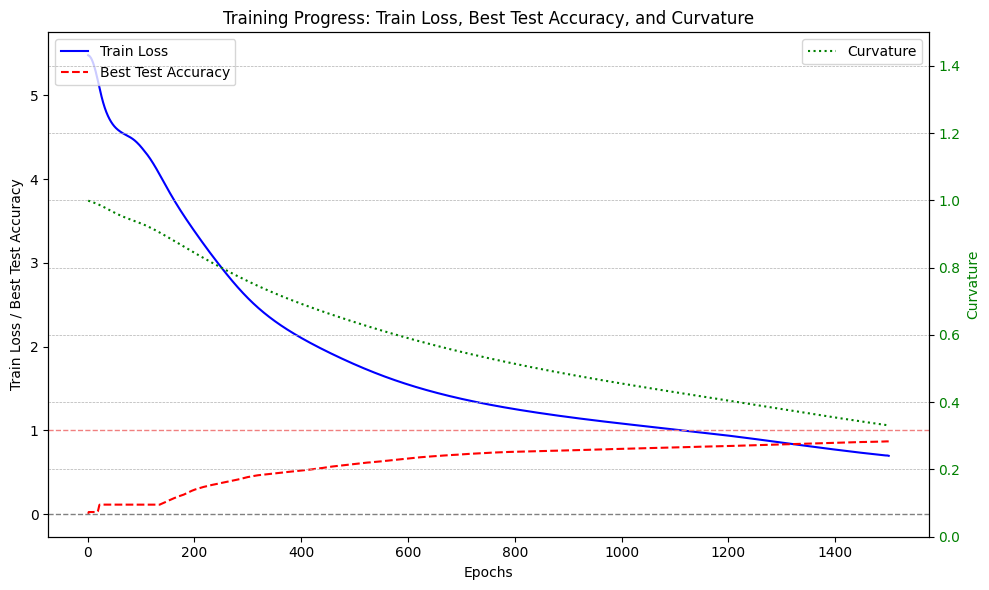


Sample Inference:
Head Entity ID: 0, Tail Entity ID: 1
Actual Relation ID: 0, Predicted Relation ID: 0


In [8]:
##########################################################
# PLOTTING
##########################################################
import matplotlib.pyplot as plt
epochs = list(range(1, num_epochs + 1))
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training loss and test accuracy on the primary y-axis
ax1.plot(epochs, train_losses, label="Train Loss", color="blue", linestyle="-")
ax1.plot(epochs, test_accuracies, label="Best Test Accuracy", color="red", linestyle="--")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Train Loss / Best Test Accuracy", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.legend(loc="upper left")


# Add a horizontal line at y=1
ax1.axhline(y=1, color="lightcoral", linestyle="--", linewidth=1, label="y=1")

# Add a horizontal line at y=0
ax1.axhline(y=0, color="grey", linestyle="--", linewidth=1, label="y=1")

# Plot curvature on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(epochs, curvatures, label="Curvature", color="green", linestyle=":")
ax2.set_ylabel("Curvature", color="green")
ax2.tick_params(axis="y", labelcolor="green")
ax2.legend(loc="upper right")

# Add title and grid
plt.title("Training Progress: Train Loss, Best Test Accuracy, and Curvature")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()


##############################################
# Inference and Evaluation
##############################################

def predict_relation(model, head_idx, tail_idx, node_emb):
    model.eval()
    with torch.no_grad():
        scores = model.classify(head_idx, tail_idx, node_emb)  # [batch_size, num_relations]
        predicted_relations = torch.argmax(scores, dim=1)
    return predicted_relations

def evaluate_full(model, criterion, heads, tails, relations, node_emb):
    model.eval()
    with torch.no_grad():
        scores = model.classify(heads, tails, node_emb)  # [batch_size, num_relations]
        loss = criterion(scores, relations).item()
        preds = torch.argmax(scores, dim=1)
        correct = (preds == relations).sum().item()
        total = relations.size(0)
        accuracy = correct / total
    return loss, accuracy

# Example Inference
sample_head = train_triples[0][0]
sample_tail = train_triples[0][2]
sample_relation = train_triples[0][1]

predicted_relation = predict_relation(model, torch.tensor([sample_head], device=device),
                                      torch.tensor([sample_tail], device=device),
                                      node_emb)

print("\nSample Inference:")
print(f"Head Entity ID: {sample_head}, Tail Entity ID: {sample_tail}")
print(f"Actual Relation ID: {sample_relation}, Predicted Relation ID: {predicted_relation.item()}")

This chunk shows the embedding space as the model trains


Starting Training...



  0%|          | 2/500 [00:00<00:31, 15.58it/s]

Epoch 001: Train Loss=5.4697, Val Loss=5.4572, Val Acc=0.0425, Best Test Acc=0.0419, Curvature: 1.006264


  2%|▏         | 12/500 [00:00<00:26, 18.38it/s]

Epoch 010: Train Loss=4.5590, Val Loss=4.5687, Val Acc=0.0501, Best Test Acc=0.1465, Curvature: 0.959582


  4%|▍         | 22/500 [00:01<00:25, 18.88it/s]

Epoch 020: Train Loss=4.2773, Val Loss=4.3210, Val Acc=0.1220, Best Test Acc=0.1465, Curvature: 0.938900


  6%|▋         | 32/500 [00:01<00:25, 18.56it/s]

Epoch 030: Train Loss=3.5496, Val Loss=3.5730, Val Acc=0.2431, Best Test Acc=0.2426, Curvature: 0.887146


  8%|▊         | 42/500 [00:02<00:24, 18.56it/s]

Epoch 040: Train Loss=2.9145, Val Loss=2.9321, Val Acc=0.3457, Best Test Acc=0.3458, Curvature: 0.815385


 10%|█         | 52/500 [00:02<00:24, 18.44it/s]

Epoch 050: Train Loss=2.4408, Val Loss=2.4452, Val Acc=0.4388, Best Test Acc=0.4383, Curvature: 0.743973


 12%|█▏        | 62/500 [00:03<00:23, 18.47it/s]

Epoch 060: Train Loss=2.0995, Val Loss=2.0826, Val Acc=0.4872, Best Test Acc=0.4869, Curvature: 0.680129


 14%|█▍        | 72/500 [00:03<00:23, 18.52it/s]

Epoch 070: Train Loss=1.8633, Val Loss=1.8335, Val Acc=0.5465, Best Test Acc=0.5449, Curvature: 0.625613


 16%|█▋        | 82/500 [00:04<00:22, 18.52it/s]

Epoch 080: Train Loss=1.6861, Val Loss=1.6288, Val Acc=0.6017, Best Test Acc=0.6006, Curvature: 0.579254


 18%|█▊        | 92/500 [00:04<00:21, 18.59it/s]

Epoch 090: Train Loss=1.5467, Val Loss=1.4655, Val Acc=0.6397, Best Test Acc=0.6378, Curvature: 0.538538


 20%|█▉        | 98/500 [00:05<00:21, 18.61it/s]

Epoch 100: Train Loss=1.4350, Val Loss=1.3311, Val Acc=0.6732, Best Test Acc=0.6706, Curvature: 0.502529


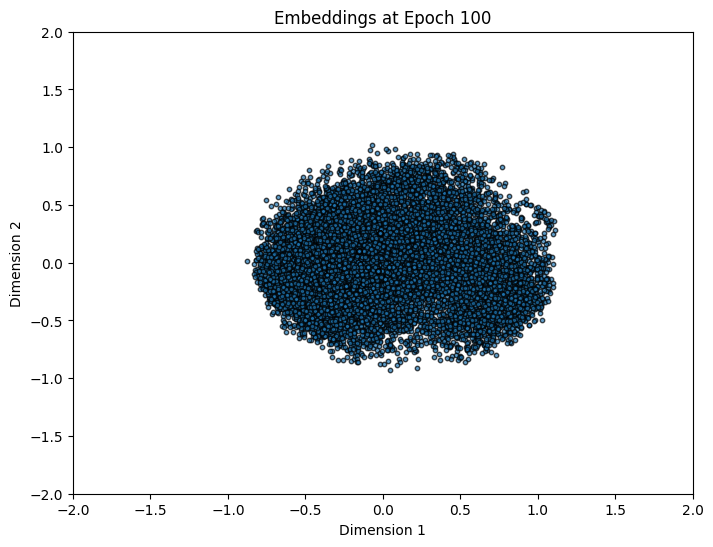

 22%|██▏       | 112/500 [00:06<00:22, 17.01it/s]

Epoch 110: Train Loss=1.3405, Val Loss=1.2197, Val Acc=0.7067, Best Test Acc=0.7074, Curvature: 0.470632


 24%|██▍       | 122/500 [00:06<00:20, 18.49it/s]

Epoch 120: Train Loss=1.2610, Val Loss=1.1295, Val Acc=0.7288, Best Test Acc=0.7295, Curvature: 0.441705


 26%|██▋       | 132/500 [00:07<00:19, 18.71it/s]

Epoch 130: Train Loss=1.1879, Val Loss=1.0442, Val Acc=0.7510, Best Test Acc=0.7486, Curvature: 0.415097


 28%|██▊       | 142/500 [00:07<00:19, 18.67it/s]

Epoch 140: Train Loss=1.1251, Val Loss=0.9699, Val Acc=0.7618, Best Test Acc=0.7594, Curvature: 0.391288


 30%|███       | 152/500 [00:08<00:18, 18.66it/s]

Epoch 150: Train Loss=1.0726, Val Loss=0.9135, Val Acc=0.7766, Best Test Acc=0.7764, Curvature: 0.369877


 32%|███▏      | 162/500 [00:09<00:18, 18.62it/s]

Epoch 160: Train Loss=1.0286, Val Loss=0.8619, Val Acc=0.7888, Best Test Acc=0.7868, Curvature: 0.350572


 34%|███▍      | 172/500 [00:09<00:17, 18.55it/s]

Epoch 170: Train Loss=0.9912, Val Loss=0.8223, Val Acc=0.7969, Best Test Acc=0.7956, Curvature: 0.333058


 36%|███▋      | 182/500 [00:10<00:17, 18.62it/s]

Epoch 180: Train Loss=0.9583, Val Loss=0.7867, Val Acc=0.8047, Best Test Acc=0.8036, Curvature: 0.316955


 38%|███▊      | 192/500 [00:10<00:16, 18.53it/s]

Epoch 190: Train Loss=0.9268, Val Loss=0.7534, Val Acc=0.8124, Best Test Acc=0.8106, Curvature: 0.301861


 40%|███▉      | 198/500 [00:10<00:16, 18.67it/s]

Epoch 200: Train Loss=0.8971, Val Loss=0.7183, Val Acc=0.8196, Best Test Acc=0.8176, Curvature: 0.287254


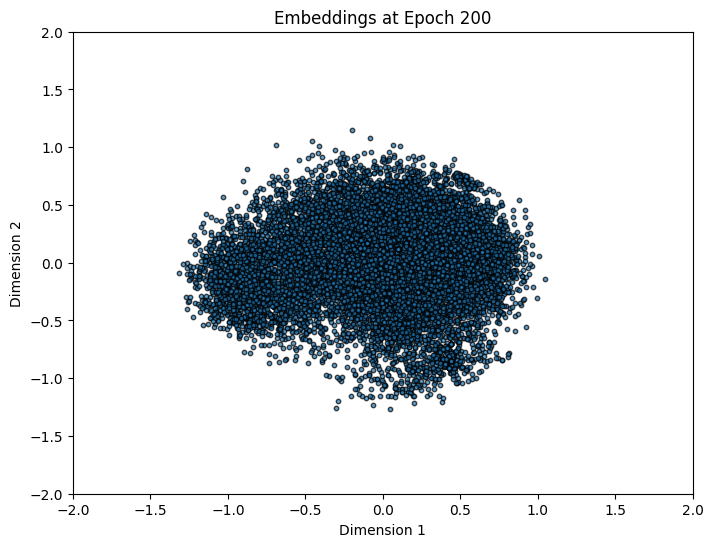

 42%|████▏     | 212/500 [00:12<00:17, 16.68it/s]

Epoch 210: Train Loss=0.8665, Val Loss=0.6891, Val Acc=0.8267, Best Test Acc=0.8241, Curvature: 0.273017


 44%|████▍     | 222/500 [00:12<00:15, 18.33it/s]

Epoch 220: Train Loss=0.8317, Val Loss=0.6538, Val Acc=0.8356, Best Test Acc=0.8309, Curvature: 0.258964


 46%|████▋     | 232/500 [00:13<00:14, 18.59it/s]

Epoch 230: Train Loss=0.7925, Val Loss=0.6142, Val Acc=0.8434, Best Test Acc=0.8405, Curvature: 0.244725


 48%|████▊     | 242/500 [00:13<00:13, 18.78it/s]

Epoch 240: Train Loss=0.8944, Val Loss=0.6755, Val Acc=0.8169, Best Test Acc=0.8433, Curvature: 0.229366


 50%|█████     | 252/500 [00:14<00:13, 18.81it/s]

Epoch 250: Train Loss=0.7688, Val Loss=0.6007, Val Acc=0.8445, Best Test Acc=0.8433, Curvature: 0.215783


 52%|█████▏    | 262/500 [00:14<00:12, 18.67it/s]

Epoch 260: Train Loss=0.7255, Val Loss=0.5433, Val Acc=0.8557, Best Test Acc=0.8534, Curvature: 0.204199


 54%|█████▍    | 272/500 [00:15<00:12, 18.63it/s]

Epoch 270: Train Loss=0.6885, Val Loss=0.5152, Val Acc=0.8642, Best Test Acc=0.8618, Curvature: 0.192834


 56%|█████▋    | 282/500 [00:15<00:11, 18.66it/s]

Epoch 280: Train Loss=0.6565, Val Loss=0.4825, Val Acc=0.8714, Best Test Acc=0.8699, Curvature: 0.181722


 58%|█████▊    | 292/500 [00:16<00:11, 18.75it/s]

Epoch 290: Train Loss=0.6268, Val Loss=0.4531, Val Acc=0.8786, Best Test Acc=0.8775, Curvature: 0.171149


 60%|█████▉    | 298/500 [00:16<00:10, 18.67it/s]

Epoch 300: Train Loss=0.5992, Val Loss=0.4251, Val Acc=0.8851, Best Test Acc=0.8821, Curvature: 0.161287


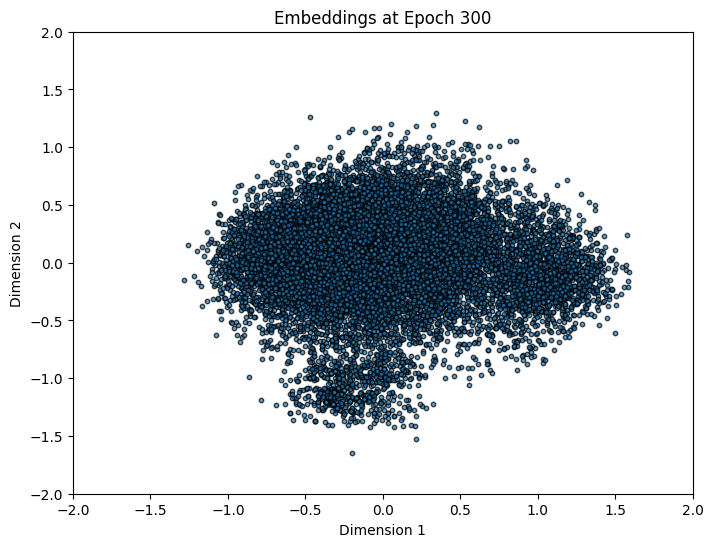

 62%|██████▏   | 312/500 [00:17<00:10, 17.22it/s]

Epoch 310: Train Loss=1.4556, Val Loss=1.2273, Val Acc=0.7211, Best Test Acc=0.8857, Curvature: 0.150865


 64%|██████▍   | 322/500 [00:18<00:09, 18.62it/s]

Epoch 320: Train Loss=0.8580, Val Loss=0.6813, Val Acc=0.8217, Best Test Acc=0.8857, Curvature: 0.143907


 66%|██████▋   | 332/500 [00:18<00:08, 18.85it/s]

Epoch 330: Train Loss=0.6983, Val Loss=0.5265, Val Acc=0.8547, Best Test Acc=0.8857, Curvature: 0.142062


 68%|██████▊   | 342/500 [00:19<00:08, 18.91it/s]

Epoch 340: Train Loss=0.6366, Val Loss=0.4726, Val Acc=0.8710, Best Test Acc=0.8857, Curvature: 0.139338


 70%|███████   | 352/500 [00:19<00:07, 18.95it/s]

Epoch 350: Train Loss=0.6023, Val Loss=0.4344, Val Acc=0.8808, Best Test Acc=0.8857, Curvature: 0.134883


 72%|███████▏  | 362/500 [00:20<00:07, 18.87it/s]

Epoch 360: Train Loss=0.5790, Val Loss=0.4100, Val Acc=0.8878, Best Test Acc=0.8857, Curvature: 0.129545


 74%|███████▍  | 372/500 [00:20<00:06, 18.64it/s]

Epoch 370: Train Loss=0.5612, Val Loss=0.3927, Val Acc=0.8922, Best Test Acc=0.8894, Curvature: 0.124074


 76%|███████▋  | 382/500 [00:21<00:06, 18.68it/s]

Epoch 380: Train Loss=0.5464, Val Loss=0.3784, Val Acc=0.8959, Best Test Acc=0.8923, Curvature: 0.118756


 78%|███████▊  | 392/500 [00:21<00:05, 18.63it/s]

Epoch 390: Train Loss=0.5335, Val Loss=0.3662, Val Acc=0.8984, Best Test Acc=0.8950, Curvature: 0.113760


 80%|███████▉  | 398/500 [00:22<00:05, 18.68it/s]

Epoch 400: Train Loss=0.5221, Val Loss=0.3549, Val Acc=0.8998, Best Test Acc=0.8978, Curvature: 0.109138


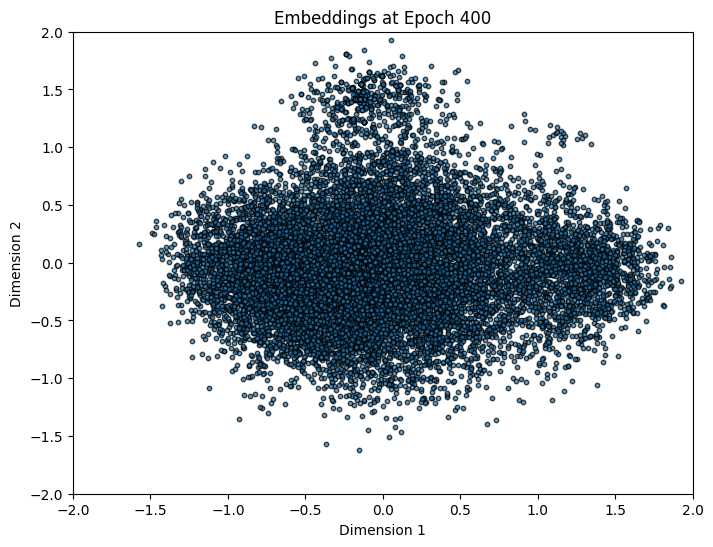

 82%|████████▏ | 412/500 [00:23<00:05, 17.03it/s]

Epoch 410: Train Loss=0.5117, Val Loss=0.3449, Val Acc=0.9031, Best Test Acc=0.8996, Curvature: 0.104881


 84%|████████▍ | 422/500 [00:23<00:04, 18.30it/s]

Epoch 420: Train Loss=0.5022, Val Loss=0.3357, Val Acc=0.9045, Best Test Acc=0.9021, Curvature: 0.100961


 86%|████████▋ | 432/500 [00:24<00:03, 18.55it/s]

Epoch 430: Train Loss=0.4935, Val Loss=0.3273, Val Acc=0.9070, Best Test Acc=0.9035, Curvature: 0.097356


 88%|████████▊ | 442/500 [00:24<00:03, 18.49it/s]

Epoch 440: Train Loss=0.4853, Val Loss=0.3195, Val Acc=0.9091, Best Test Acc=0.9056, Curvature: 0.094038


 90%|█████████ | 452/500 [00:25<00:02, 18.62it/s]

Epoch 450: Train Loss=0.4777, Val Loss=0.3122, Val Acc=0.9110, Best Test Acc=0.9069, Curvature: 0.090969


 92%|█████████▏| 462/500 [00:25<00:02, 18.46it/s]

Epoch 460: Train Loss=0.4705, Val Loss=0.3055, Val Acc=0.9123, Best Test Acc=0.9085, Curvature: 0.088107


 94%|█████████▍| 472/500 [00:26<00:01, 18.50it/s]

Epoch 470: Train Loss=0.4637, Val Loss=0.2991, Val Acc=0.9143, Best Test Acc=0.9103, Curvature: 0.085450


 96%|█████████▋| 482/500 [00:27<00:00, 18.54it/s]

Epoch 480: Train Loss=0.4574, Val Loss=0.2931, Val Acc=0.9163, Best Test Acc=0.9112, Curvature: 0.082981


 98%|█████████▊| 492/500 [00:27<00:00, 18.72it/s]

Epoch 490: Train Loss=0.4513, Val Loss=0.2875, Val Acc=0.9169, Best Test Acc=0.9125, Curvature: 0.080690


100%|█████████▉| 498/500 [00:27<00:00, 18.67it/s]

Epoch 500: Train Loss=0.4457, Val Loss=0.2823, Val Acc=0.9181, Best Test Acc=0.9140, Curvature: 0.078609


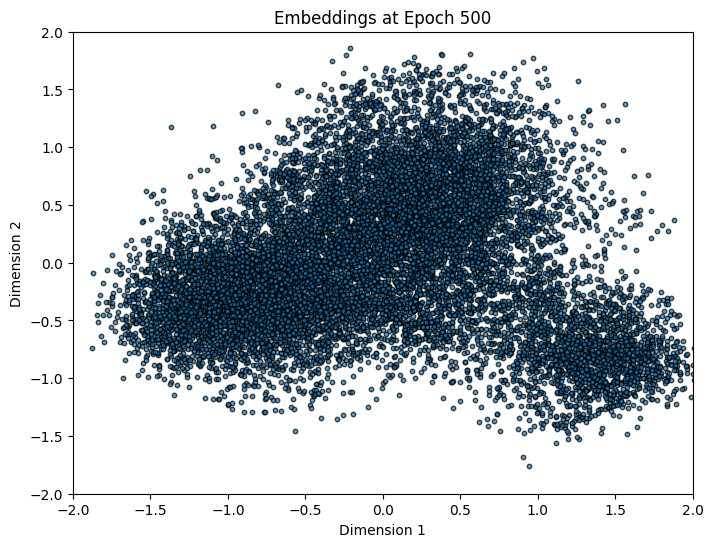

100%|██████████| 500/500 [00:28<00:00, 17.68it/s]


Training Completed.
Best Validation Accuracy: 0.9181
Corresponding Test Accuracy: 0.9140
Curvature: 0.078609


In [9]:
# EMBEDDING VISUALS
# 12/13: 6:50 PM
# valentina

import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import geoopt

# Assuming LinkPredictionModel and necessary imports are already defined
# Let's initialize the model and other training components

hidden_dim = 128  # Reduced hidden dimension
num_epochs = 500
best_val_accuracy = 0.0
best_test_accuracy = 0.0

# Initialize the model
model = LinkPredictionModel(num_features=embedding_dim, hidden_dim=hidden_dim, num_relations=num_relations, c=1.0).to(device)

# Optimizer setup (Riemannian mixed precision)
optimizer = geoopt.optim.RiemannianAdam(model.parameters(), lr=1e-2)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Prepare data
train_heads, train_tails, train_relations = prepare_data(train_triples)
valid_heads, valid_tails, valid_relations = prepare_data(valid_triples)
test_heads, test_tails, test_relations = prepare_data(test_triples)

curvatures, train_losses, val_losses, val_accuracies, test_accuracies = [], [], [], [], []

# Initialize PCA for visualization
pca = PCA(n_components=2)

# Training Loop
print("\nStarting Training...\n")
for epoch in tqdm(range(1, num_epochs + 1)):
    # Forward pass to get node embeddings in hyperbolic space
    node_emb_hyperbolic = model(features, norm_adj)  # [num_nodes, hidden_dim] in hyperbolic space

    # Training
    train_loss = train_epoch(model, optimizer, criterion, train_heads, train_tails, train_relations, node_emb_hyperbolic)

    # Evaluation on Validation Set
    val_loss, val_accuracy = evaluate(model, criterion, valid_heads, valid_tails, valid_relations, node_emb_hyperbolic)

    # Early Stopping and Best Model Tracking
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Evaluate on Test Set
        test_loss, test_accuracy = evaluate(model, criterion, test_heads, test_tails, test_relations, node_emb_hyperbolic)
        best_test_accuracy = test_accuracy

    # Print Epoch Results
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}, Best Test Acc={best_test_accuracy:.4f}, Curvature: {model.gcn.manifold.c.item():.6f}")

    # Save the curvature, losses, and accuracies
    curvatures.append(model.gcn.manifold.c.item())
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    # Visualize embeddings every 100 epochs
    if epoch % 100 == 0:
        # Project the hyperbolic embeddings to Euclidean space using expmap0
        node_emb_euclidean = model.gcn.manifold.expmap0(node_emb_hyperbolic)  # Map hyperbolic to Euclidean space

        # Reduce the dimensionality of the embeddings to 2D for visualization
        node_emb_2d = pca.fit_transform(node_emb_euclidean.cpu().detach().numpy())

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(node_emb_2d[:, 0], node_emb_2d[:, 1], alpha=0.7, edgecolors='k', s=10)
        plt.title(f"Embeddings at Epoch {epoch}")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.xlim(-2, 2)  # Adjust as needed
        plt.ylim(-2, 2)  # Adjust as needed
        plt.show()

print("\nTraining Completed.")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Corresponding Test Accuracy: {best_test_accuracy:.4f}")
print(f"Curvature: {model.gcn.manifold.c.item():.6f}")


## DISEASE

This loads in the Disease Data

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from torch import optim
import geoopt
from geoopt import ManifoldParameter
import os
from tqdm import tqdm
import pandas as pd
from scipy.sparse import csr_matrix, diags
import numpy as np
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

##############################################
# Data Loading and Preprocessing
##############################################

def load_synthetic_data(dataset_str, use_feats, data_path):
    object_to_idx = {}
    idx_counter = 0
    edges = []

    # Read all edges from the CSV file
    with open(os.path.join(data_path, f"{dataset_str}.edges.csv"), 'r') as f:
        all_edges = f.readlines()

    for line in all_edges:
        n1, n2 = line.rstrip().split(',')

        # Assign unique indices to nodes
        if n1 in object_to_idx:
            i = object_to_idx[n1]
        else:
            i = idx_counter
            object_to_idx[n1] = i
            idx_counter += 1

        if n2 in object_to_idx:
            j = object_to_idx[n2]
        else:
            j = idx_counter
            object_to_idx[n2] = j
            idx_counter += 1

        edges.append((i, j))

    num_nodes = len(object_to_idx)

    # Initialize adjacency matrix using LIL format for efficient assignment
    adj = sp.lil_matrix((num_nodes, num_nodes), dtype=np.float32)

    for i, j in edges:
        adj[i, j] = 1.0  # Undirected graph: set both (i, j) and (j, i)
        adj[j, i] = 1.0

    # Convert adjacency matrix to CSR format for efficient arithmetic operations
    adj = adj.tocsr()

    # Load features
    if use_feats:
        features = sp.load_npz(os.path.join(data_path, f"{dataset_str}.feats.npz")).astype(np.float32)
    else:
        features = sp.eye(adj.shape[0], dtype=np.float32)

    # Load labels
    labels = np.load(os.path.join(data_path, f"{dataset_str}.labels.npy"))

    return adj, features, labels, object_to_idx


# Define file paths
data_path = ''  # Update this to your actual data path
dataset_str = 'disease_lp'

# Load data
adj, features, labels, object_to_idx = load_synthetic_data(dataset_str, use_feats=True, data_path=data_path)

num_nodes = adj.shape[0]
num_features = features.shape[1]
num_classes = len(np.unique(labels))  # Assuming labels are integer-encoded

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Features: {num_features}")
print(f"Number of Classes: {num_classes}")

# Convert adjacency matrix to a sparse matrix and add self-loops
adj = adj + diags([1e-5] * num_nodes)

# Compute degree
degrees = np.array(adj.sum(axis=1)).flatten()

# Compute D^-0.5 (inverse square root of degree matrix)
inv_sqrt_deg = np.power(degrees, -0.5)
inv_sqrt_deg[np.isinf(inv_sqrt_deg)] = 0
D_inv_sqrt = diags(inv_sqrt_deg)

# Normalize adjacency matrix: D^-0.5 * A * D^-0.5
norm_adj = D_inv_sqrt @ adj @ D_inv_sqrt

# Convert back to a PyTorch tensor
norm_adj = torch.tensor(norm_adj.toarray(), dtype=torch.float32)

# Node Features: Load from the features matrix
features = csr_matrix(features)
features = torch.tensor(features.toarray(), dtype=torch.float32)

# Move tensors to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features, norm_adj = features.to(device), norm_adj.to(device)

print(f"Using device: {device}")

Number of Nodes: 2665
Number of Features: 11
Number of Classes: 2
Using device: cuda


Definition of Disease Task and HGCN as well as training loop

In [11]:
from scipy.sparse import csr_matrix, diags
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split

class HyperbolicLinear(nn.Module):
    """
    Hyperbolic linear layer using the Poincaré Ball model.
    """
    def __init__(self, manifold, in_features, out_features, bias=True):
        super(HyperbolicLinear, self).__init__()
        self.manifold = manifold
        self.in_features = in_features
        self.out_features = out_features
        # ManifoldParameter for weight in Euclidean space
        self.weight = ManifoldParameter(torch.randn(out_features, in_features) * 0.01, manifold=geoopt.Euclidean())
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        # x is on manifold. Map to tangent space at 0, apply linear, map back
        x_tan = self.manifold.logmap0(x, dim=-1)
        out = F.linear(x_tan, self.weight, self.bias)
        out = self.manifold.expmap0(out, dim=-1)
        return out

class HyperbolicGCNLayer(nn.Module):
    def __init__(self, manifold, in_features, out_features):
        super(HyperbolicGCNLayer, self).__init__()
        self.manifold = manifold
        self.lin = HyperbolicLinear(manifold, in_features, out_features)

    def forward(self, x, adj):
        # x on manifold
        x_tan = self.manifold.logmap0(x, dim=-1)
        x_agg_tan = adj @ x_tan  # Aggregate in tangent space
        x_agg = self.manifold.expmap0(x_agg_tan, dim=-1)
        return self.lin(x_agg)

class HyperbolicGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, c=1.0):
        super(HyperbolicGCN, self).__init__()
        # Initialize the manifold inside the model to ensure its parameters are included
        self.manifold = geoopt.PoincareBall(c=c, learnable=True)
        self.layer1 = HyperbolicGCNLayer(self.manifold, num_features, hidden_dim)
        self.layer2 = HyperbolicGCNLayer(self.manifold, hidden_dim, hidden_dim)

    def forward(self, x, adj):
        x = self.manifold.expmap0(x, dim=-1)  # Ensure x is on manifold
        x = self.layer1(x, adj)
        # Hyperbolic activation: apply tanh in tangent space
        x_tan = self.manifold.logmap0(x, dim=-1)
        x_tan = torch.tanh(x_tan)
        x = self.manifold.expmap0(x_tan, dim=-1)
        x = self.layer2(x, adj)
        return x

class LinkPredictionModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_relations, c=1.0):
        super(LinkPredictionModel, self).__init__()
        self.gcn = HyperbolicGCN(num_features, hidden_dim, c=c)
        # Define a classifier that takes concatenated head and tail embeddings
        self.classifier = nn.Linear(hidden_dim * 2, num_relations)  # Multi-class classification
        nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, x, adj):
        node_emb = self.gcn(x, adj)  # [num_nodes, hidden_dim]
        return node_emb

    def classify(self, head_idx, tail_idx, node_emb):
        # Retrieve embeddings
        head_emb = node_emb[head_idx]     # [batch_size, hidden_dim]
        tail_emb = node_emb[tail_idx]     # [batch_size, hidden_dim]
        # Concatenate head and tail embeddings
        combined = torch.cat([head_emb, tail_emb], dim=1)  # [batch_size, hidden_dim * 2]
        scores = self.classifier(combined)  # [batch_size, num_relations]
        return scores

##############################################
# Training and Evaluation Utilities
##############################################

def prepare_data(triples):
    """
    Prepare tensors for head, tail, and relation indices.
    """
    triples = torch.tensor(triples, dtype=torch.long, device=device)
    heads = triples[:, 0]
    relations = triples[:, 1]
    tails = triples[:, 2]
    return heads, tails, relations

def train_epoch(model, optimizer, criterion, heads, tails, relations, node_emb):
    model.train()
    optimizer.zero_grad()

    # Get relation scores
    scores = model.classify(heads, tails, node_emb)  # [batch_size, num_relations]

    # Compute loss
    loss = criterion(scores, relations)
    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate(model, criterion, heads, tails, relations, node_emb):
    model.eval()
    with torch.no_grad():
        scores = model.classify(heads, tails, node_emb)  # [batch_size, num_relations]
        loss = criterion(scores, relations).item()
        preds = torch.argmax(scores, dim=1)
        correct = (preds == relations).sum().item()
        total = relations.size(0)
        accuracy = correct / total
    return loss, accuracy

##############################################
# Training Loop
##############################################

# Generate Train, Validation, and Test Splits for Link Prediction

def generate_negative_edges(adj_matrix, num_neg_samples, excluded_edges=set()):
    neg_edges = set()
    while len(neg_edges) < num_neg_samples:
        i = random.randint(0, num_nodes - 1)
        j = random.randint(0, num_nodes - 1)
        if i == j:
            continue
        if adj_matrix[i, j] == 0 and (i, j) not in excluded_edges and (j, i) not in excluded_edges:
            neg_edges.add((i, j))
    return list(neg_edges)

# Extract existing edges
existing_edges = set()
adj_coo = adj.tocoo()
for i, j in zip(adj_coo.row, adj_coo.col):
    if i < j:  # To avoid duplicates in undirected graph
        existing_edges.add((i, j))

# Number of positive and negative samples
num_positive = len(existing_edges)
num_negative = num_positive  # Balance the dataset

# Generate negative edges
negative_edges = generate_negative_edges(adj, num_negative, excluded_edges=existing_edges)

# Create labels: 1 for positive, 0 for negative
positive_labels = np.ones(num_positive)
negative_labels = np.zeros(num_negative)

# Combine positive and negative edges
all_edges = list(existing_edges) + negative_edges
all_labels = np.concatenate([positive_labels, negative_labels])

# Split into train, val, test
train_edges, temp_edges, train_labels, temp_labels = train_test_split(all_edges, all_labels, test_size=0.3, random_state=42, stratify=all_labels)
val_edges, test_edges, val_labels, test_labels = train_test_split(temp_edges, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

# Prepare training, validation, and test data
train_triples = [(h, r, t) for (h, t), r in zip(train_edges, train_labels)]
val_triples = [(h, r, t) for (h, t), r in zip(val_edges, val_labels)]
test_triples = [(h, r, t) for (h, t), r in zip(test_edges, test_labels)]

train_heads, train_tails, train_relations = prepare_data(train_triples)
val_heads, val_tails, val_relations = prepare_data(val_triples)
test_heads, test_tails, test_relations = prepare_data(test_triples)

# Initialize the model
hidden_dim = 128
num_relations = len(np.unique(train_labels))
model = LinkPredictionModel(num_features=num_features, hidden_dim=hidden_dim, num_relations=num_relations, c=1).to(device)

# Initialize input: ensure features are on the manifold
with torch.no_grad():
    x = model.gcn.manifold.expmap0(features, dim=-1)

# Optimizer Choices:
riemannian_adam = geoopt.optim.RiemannianAdam(model.parameters(), lr=1e-4)
riemannian_sgd = geoopt.optim.RiemannianSGD(model.parameters(), lr=1e-2)
riemannian_mixed_precision = MixedPrecisionRiemannianAdam(model.parameters(), lr=1e-2)
riemannian_adagrad = RiemannianAdagrad(model.parameters(), lr=1e-2) # error currently

# SET OPTIMIZER:
optimizer = riemannian_adam

# Define loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Training parameters
num_epochs = 500
best_val_accuracy = 0.0
best_test_accuracy = 0.0

curvatures, train_losses, val_losses, val_accuracies, test_accuracies = [], [], [], [], []

print("\nStarting Training...\n")
for epoch in tqdm(range(1, num_epochs + 1)):
    # Forward pass to get node embeddings
    node_emb = model(features, norm_adj)  # [num_nodes, hidden_dim]

    # Training
    train_loss = train_epoch(model, optimizer, criterion, train_heads, train_tails, train_relations, node_emb)

    # Evaluation on Validation Set
    val_loss, val_accuracy = evaluate(model, criterion, val_heads, val_tails, val_relations, node_emb)

    # Early Stopping and Best Model Tracking
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Evaluate on Test Set
        test_loss, test_accuracy = evaluate(model, criterion, test_heads, test_tails, test_relations, node_emb)
        best_test_accuracy = test_accuracy

    # Print Epoch Results
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}, Best Test Acc={best_test_accuracy:.4f}, Curvature: {model.gcn.manifold.c.item():.6f}")

    curvatures.append(model.gcn.manifold.c.item())
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    # Visualize embeddings every 10 epochs (or at any frequency)
    #if epoch % 1000 == 0:
        #visualize_embeddings_in_poincare(node_emb, labels, model.gcn.manifold, epoch=epoch)

print("\nTraining Completed.")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Corresponding Test Accuracy: {best_test_accuracy:.4f}")
print(f"Curvature: {model.gcn.manifold.c.item():.6f}")


Starting Training...



  1%|          | 6/500 [00:01<01:14,  6.65it/s]

Epoch 001: Train Loss=0.6933, Val Loss=0.6933, Val Acc=0.5006, Best Test Acc=0.5000, Curvature: 0.999937


  3%|▎         | 16/500 [00:01<00:25, 18.64it/s]

Epoch 010: Train Loss=0.6906, Val Loss=0.6907, Val Acc=0.5156, Best Test Acc=0.7525, Curvature: 1.000210


  5%|▌         | 26/500 [00:01<00:16, 29.29it/s]

Epoch 020: Train Loss=0.6861, Val Loss=0.6863, Val Acc=0.5156, Best Test Acc=0.7525, Curvature: 1.000874


  7%|▋         | 36/500 [00:01<00:12, 36.41it/s]

Epoch 030: Train Loss=0.6786, Val Loss=0.6789, Val Acc=0.5532, Best Test Acc=0.7525, Curvature: 1.001650


  9%|▉         | 46/500 [00:02<00:11, 41.24it/s]

Epoch 040: Train Loss=0.6676, Val Loss=0.6682, Val Acc=0.5594, Best Test Acc=0.7525, Curvature: 1.002529


 11%|█         | 56/500 [00:02<00:10, 44.13it/s]

Epoch 050: Train Loss=0.6542, Val Loss=0.6553, Val Acc=0.5720, Best Test Acc=0.7525, Curvature: 1.003500


 13%|█▎        | 66/500 [00:02<00:09, 45.46it/s]

Epoch 060: Train Loss=0.6408, Val Loss=0.6424, Val Acc=0.5970, Best Test Acc=0.7525, Curvature: 1.004540


 15%|█▌        | 76/500 [00:02<00:09, 45.83it/s]

Epoch 070: Train Loss=0.6280, Val Loss=0.6304, Val Acc=0.6496, Best Test Acc=0.7525, Curvature: 1.005592


 17%|█▋        | 86/500 [00:02<00:08, 46.28it/s]

Epoch 080: Train Loss=0.6155, Val Loss=0.6185, Val Acc=0.7071, Best Test Acc=0.7525, Curvature: 1.006536


 19%|█▉        | 96/500 [00:03<00:08, 46.28it/s]

Epoch 090: Train Loss=0.6026, Val Loss=0.6062, Val Acc=0.7597, Best Test Acc=0.7550, Curvature: 1.007195


 21%|██        | 106/500 [00:03<00:08, 46.42it/s]

Epoch 100: Train Loss=0.5893, Val Loss=0.5933, Val Acc=0.8060, Best Test Acc=0.8037, Curvature: 1.007319


 23%|██▎       | 116/500 [00:03<00:08, 46.77it/s]

Epoch 110: Train Loss=0.5753, Val Loss=0.5797, Val Acc=0.8436, Best Test Acc=0.8550, Curvature: 1.006762


 25%|██▌       | 126/500 [00:03<00:08, 46.64it/s]

Epoch 120: Train Loss=0.5611, Val Loss=0.5659, Val Acc=0.8623, Best Test Acc=0.8675, Curvature: 1.005699


 27%|██▋       | 136/500 [00:03<00:07, 46.21it/s]

Epoch 130: Train Loss=0.5471, Val Loss=0.5522, Val Acc=0.8748, Best Test Acc=0.8762, Curvature: 1.004408


 29%|██▉       | 146/500 [00:04<00:07, 46.31it/s]

Epoch 140: Train Loss=0.5336, Val Loss=0.5390, Val Acc=0.8698, Best Test Acc=0.8762, Curvature: 1.003046


 31%|███       | 156/500 [00:04<00:07, 46.41it/s]

Epoch 150: Train Loss=0.5208, Val Loss=0.5266, Val Acc=0.8648, Best Test Acc=0.8762, Curvature: 1.001678


 33%|███▎      | 166/500 [00:04<00:07, 46.59it/s]

Epoch 160: Train Loss=0.5087, Val Loss=0.5148, Val Acc=0.8573, Best Test Acc=0.8762, Curvature: 1.000325


 35%|███▌      | 176/500 [00:04<00:06, 46.59it/s]

Epoch 170: Train Loss=0.4972, Val Loss=0.5037, Val Acc=0.8523, Best Test Acc=0.8762, Curvature: 0.998999


 37%|███▋      | 186/500 [00:05<00:06, 46.62it/s]

Epoch 180: Train Loss=0.4863, Val Loss=0.4931, Val Acc=0.8498, Best Test Acc=0.8762, Curvature: 0.997699


 39%|███▉      | 196/500 [00:05<00:06, 46.66it/s]

Epoch 190: Train Loss=0.4760, Val Loss=0.4830, Val Acc=0.8498, Best Test Acc=0.8762, Curvature: 0.996427


 41%|████      | 206/500 [00:05<00:06, 46.61it/s]

Epoch 200: Train Loss=0.4661, Val Loss=0.4734, Val Acc=0.8511, Best Test Acc=0.8762, Curvature: 0.995179


 43%|████▎     | 216/500 [00:05<00:06, 46.42it/s]

Epoch 210: Train Loss=0.4568, Val Loss=0.4643, Val Acc=0.8523, Best Test Acc=0.8762, Curvature: 0.993956


 45%|████▌     | 226/500 [00:05<00:05, 46.52it/s]

Epoch 220: Train Loss=0.4480, Val Loss=0.4557, Val Acc=0.8511, Best Test Acc=0.8762, Curvature: 0.992755


 47%|████▋     | 236/500 [00:06<00:05, 46.50it/s]

Epoch 230: Train Loss=0.4397, Val Loss=0.4475, Val Acc=0.8536, Best Test Acc=0.8762, Curvature: 0.991578


 49%|████▉     | 246/500 [00:06<00:05, 46.59it/s]

Epoch 240: Train Loss=0.4319, Val Loss=0.4399, Val Acc=0.8573, Best Test Acc=0.8762, Curvature: 0.990424


 51%|█████     | 256/500 [00:06<00:05, 46.72it/s]

Epoch 250: Train Loss=0.4245, Val Loss=0.4327, Val Acc=0.8623, Best Test Acc=0.8762, Curvature: 0.989294


 53%|█████▎    | 266/500 [00:06<00:04, 46.98it/s]

Epoch 260: Train Loss=0.4176, Val Loss=0.4260, Val Acc=0.8661, Best Test Acc=0.8762, Curvature: 0.988187


 55%|█████▌    | 276/500 [00:06<00:04, 47.15it/s]

Epoch 270: Train Loss=0.4111, Val Loss=0.4197, Val Acc=0.8673, Best Test Acc=0.8762, Curvature: 0.987104


 57%|█████▋    | 286/500 [00:07<00:04, 47.02it/s]

Epoch 280: Train Loss=0.4050, Val Loss=0.4137, Val Acc=0.8723, Best Test Acc=0.8762, Curvature: 0.986045


 59%|█████▉    | 296/500 [00:07<00:04, 47.02it/s]

Epoch 290: Train Loss=0.3992, Val Loss=0.4082, Val Acc=0.8761, Best Test Acc=0.8762, Curvature: 0.985007


 61%|██████    | 306/500 [00:07<00:04, 47.10it/s]

Epoch 300: Train Loss=0.3938, Val Loss=0.4029, Val Acc=0.8798, Best Test Acc=0.8788, Curvature: 0.983990


 63%|██████▎   | 316/500 [00:07<00:03, 46.56it/s]

Epoch 310: Train Loss=0.3887, Val Loss=0.3980, Val Acc=0.8836, Best Test Acc=0.8800, Curvature: 0.982996


 65%|██████▌   | 326/500 [00:08<00:03, 46.46it/s]

Epoch 320: Train Loss=0.3838, Val Loss=0.3933, Val Acc=0.8874, Best Test Acc=0.8825, Curvature: 0.982023


 67%|██████▋   | 336/500 [00:08<00:03, 46.76it/s]

Epoch 330: Train Loss=0.3792, Val Loss=0.3889, Val Acc=0.8886, Best Test Acc=0.8825, Curvature: 0.981071


 69%|██████▉   | 346/500 [00:08<00:03, 46.94it/s]

Epoch 340: Train Loss=0.3748, Val Loss=0.3847, Val Acc=0.8886, Best Test Acc=0.8825, Curvature: 0.980138


 71%|███████   | 356/500 [00:08<00:03, 46.99it/s]

Epoch 350: Train Loss=0.3706, Val Loss=0.3807, Val Acc=0.8911, Best Test Acc=0.8912, Curvature: 0.979226


 73%|███████▎  | 366/500 [00:08<00:02, 47.11it/s]

Epoch 360: Train Loss=0.3666, Val Loss=0.3769, Val Acc=0.8949, Best Test Acc=0.8962, Curvature: 0.978332


 75%|███████▌  | 376/500 [00:09<00:02, 46.85it/s]

Epoch 370: Train Loss=0.3627, Val Loss=0.3732, Val Acc=0.8961, Best Test Acc=0.8962, Curvature: 0.977457


 77%|███████▋  | 386/500 [00:09<00:02, 47.17it/s]

Epoch 380: Train Loss=0.3591, Val Loss=0.3698, Val Acc=0.8999, Best Test Acc=0.8988, Curvature: 0.976599


 79%|███████▉  | 396/500 [00:09<00:02, 47.03it/s]

Epoch 390: Train Loss=0.3556, Val Loss=0.3664, Val Acc=0.8999, Best Test Acc=0.8988, Curvature: 0.975759


 81%|████████  | 406/500 [00:09<00:02, 46.83it/s]

Epoch 400: Train Loss=0.3522, Val Loss=0.3632, Val Acc=0.9011, Best Test Acc=0.8988, Curvature: 0.974935


 83%|████████▎ | 416/500 [00:09<00:01, 46.59it/s]

Epoch 410: Train Loss=0.3489, Val Loss=0.3602, Val Acc=0.9024, Best Test Acc=0.9000, Curvature: 0.974128


 85%|████████▌ | 426/500 [00:10<00:01, 46.76it/s]

Epoch 420: Train Loss=0.3458, Val Loss=0.3572, Val Acc=0.9024, Best Test Acc=0.9012, Curvature: 0.973337


 87%|████████▋ | 436/500 [00:10<00:01, 46.97it/s]

Epoch 430: Train Loss=0.3427, Val Loss=0.3544, Val Acc=0.9024, Best Test Acc=0.9012, Curvature: 0.972562


 89%|████████▉ | 446/500 [00:10<00:01, 47.32it/s]

Epoch 440: Train Loss=0.3398, Val Loss=0.3517, Val Acc=0.9036, Best Test Acc=0.9012, Curvature: 0.971802


 91%|█████████ | 456/500 [00:10<00:00, 47.02it/s]

Epoch 450: Train Loss=0.3370, Val Loss=0.3490, Val Acc=0.9061, Best Test Acc=0.9075, Curvature: 0.971056


 93%|█████████▎| 466/500 [00:11<00:00, 46.92it/s]

Epoch 460: Train Loss=0.3342, Val Loss=0.3465, Val Acc=0.9061, Best Test Acc=0.9075, Curvature: 0.970327


 95%|█████████▌| 476/500 [00:11<00:00, 47.06it/s]

Epoch 470: Train Loss=0.3316, Val Loss=0.3440, Val Acc=0.9074, Best Test Acc=0.9100, Curvature: 0.969612


 97%|█████████▋| 486/500 [00:11<00:00, 46.08it/s]

Epoch 480: Train Loss=0.3290, Val Loss=0.3416, Val Acc=0.9086, Best Test Acc=0.9100, Curvature: 0.968913


 99%|█████████▉| 496/500 [00:11<00:00, 46.33it/s]

Epoch 490: Train Loss=0.3265, Val Loss=0.3393, Val Acc=0.9074, Best Test Acc=0.9100, Curvature: 0.968226


100%|██████████| 500/500 [00:11<00:00, 42.45it/s]

Epoch 500: Train Loss=0.3241, Val Loss=0.3371, Val Acc=0.9074, Best Test Acc=0.9100, Curvature: 0.967552

Training Completed.
Best Validation Accuracy: 0.9086
Corresponding Test Accuracy: 0.9100
Curvature: 0.967552


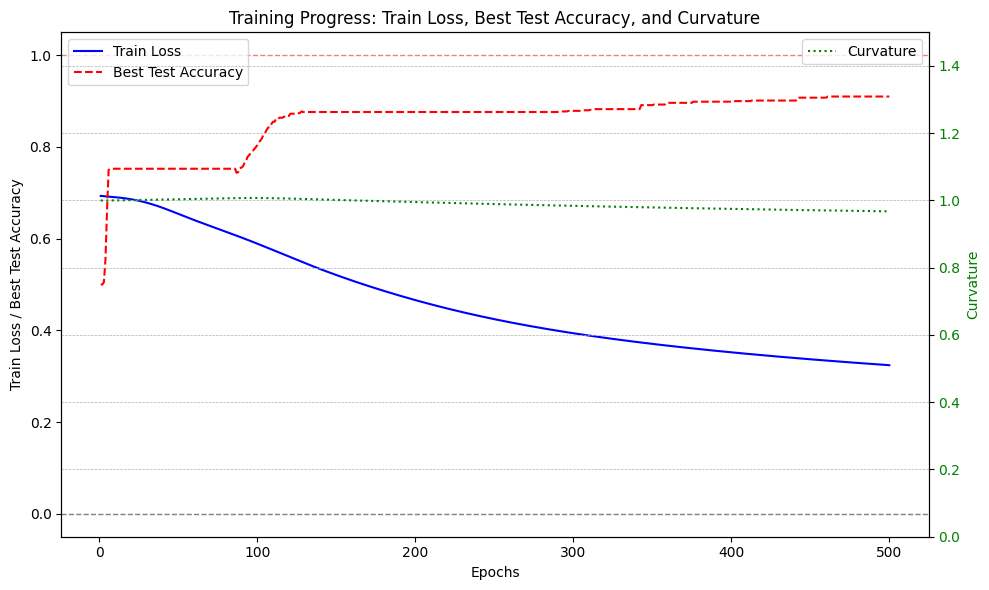

In [12]:
##########################################################
# PLOTTING
##########################################################
import matplotlib.pyplot as plt
epochs = list(range(1, num_epochs + 1))
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training loss and test accuracy on the primary y-axis
ax1.plot(epochs, train_losses, label="Train Loss", color="blue", linestyle="-")
ax1.plot(epochs, test_accuracies, label="Best Test Accuracy", color="red", linestyle="--")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Train Loss / Best Test Accuracy", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.legend(loc="upper left")


# Add a horizontal line at y=1
ax1.axhline(y=1, color="lightcoral", linestyle="--", linewidth=1, label="y=1")

# Add a horizontal line at y=0
ax1.axhline(y=0, color="grey", linestyle="--", linewidth=1, label="y=1")

# Plot curvature on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(epochs, curvatures, label="Curvature", color="green", linestyle=":")
ax2.set_ylabel("Curvature", color="green")
ax2.tick_params(axis="y", labelcolor="green")
ax2.legend(loc="upper right")

# Add title and grid
plt.title("Training Progress: Train Loss, Best Test Accuracy, and Curvature")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()

## PUBMED

Load Pubmed Data

In [13]:
# Define file paths
data_path = ''  # **Update this to your actual data path**
dataset_str = 'pubmed'  # pubmed

import os
import sys
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from torch import optim
import geoopt
from geoopt import ManifoldParameter
from tqdm import tqdm
import pandas as pd
from scipy.sparse import csr_matrix, diags, vstack
import numpy as np
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

##############################################
# Auxiliary Functions
##############################################

def parse_index_file(filename):
    """Parse index file to list of indices."""
    index = []
    with open(filename, 'r') as f:
        for line in f:
            index.append(int(line.strip()))
    return index

##############################################
# Data Loading and Preprocessing
##############################################

def load_citation_data(dataset_str, use_feats, data_path, split_seed=None):
    """
    Load citation network dataset (Cora, Citeseer, Pubmed).

    Parameters:
    - dataset_str: Name of the dataset (e.g., 'cora')
    - use_feats: Whether to use features or identity matrix
    - data_path: Path to the dataset files
    - split_seed: Seed for splitting data (optional)

    Returns:
    - adj: Adjacency matrix (scipy sparse CSR matrix)
    - features: Feature matrix (scipy sparse CSR matrix)
    - labels: Numpy array of labels
    - idx_train: List of training indices
    - idx_val: List of validation indices
    - idx_test: List of test indices
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for name in names:
        file_path = os.path.join(data_path, f"ind.{dataset_str}.{name}")
        with open(file_path, 'rb') as f:
            if sys.version_info > (3, 0):
                out = pkl.load(f, encoding='latin1')
            else:
                out = pkl.load(f)
            objects.append(out)

    x, y, tx, ty, allx, ally, graph = tuple(objects)

    test_idx_reorder = parse_index_file(os.path.join(data_path, f"ind.{dataset_str}.test.index"))
    test_idx_range = np.sort(test_idx_reorder)

    # Handle feature matrices
    if isinstance(allx, sp.csr_matrix):
        features = sp.vstack((allx, tx)).tolil()
    else:
        features = sp.vstack((allx, tx)).tolil()

    features[test_idx_reorder, :] = features[test_idx_range, :]

    # Handle labels
    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]
    labels = np.argmax(labels, axis=1)

    # Define train, validation, and test indices
    idx_test = test_idx_range.tolist()
    idx_train = list(range(len(y)))
    idx_val = list(range(len(y), len(y) + 500))  # Adjust the validation size as needed

    # Create adjacency matrix
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    if not use_feats:
        features = sp.eye(adj.shape[0])

    return adj, features, labels, idx_train, idx_val, idx_test

# Load data using load_citation_data
adj, features, labels, idx_train, idx_val, idx_test = load_citation_data(
    dataset_str=dataset_str,
    use_feats=True,
    data_path=data_path
)

num_nodes = adj.shape[0]
num_features = features.shape[1]
num_classes = len(np.unique(labels))  # Assuming labels are integer-encoded

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Features: {num_features}")
print(f"Number of Classes: {num_classes}")

# Convert adjacency matrix to a sparse matrix and add self-loops
adj = adj + diags([1e-5] * num_nodes)  # Small value to prevent singularity

# Compute degree
degrees = np.array(adj.sum(axis=1)).flatten()

# Compute D^-0.5 (inverse square root of degree matrix)
inv_sqrt_deg = np.power(degrees, -0.5)
inv_sqrt_deg[np.isinf(inv_sqrt_deg)] = 0
D_inv_sqrt = diags(inv_sqrt_deg)

# Normalize adjacency matrix: D^-0.5 * A * D^-0.5
norm_adj = D_inv_sqrt.dot(adj).dot(D_inv_sqrt)

# Convert back to a PyTorch tensor
norm_adj = torch.tensor(norm_adj.toarray(), dtype=torch.float32)

# Node Features: Load from the features matrix
features = features.tocsr()
features = torch.tensor(features.toarray(), dtype=torch.float32)

# Move tensors to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features, norm_adj = features.to(device), norm_adj.to(device)

print(f"Using device: {device}")

# Generate Train, Validation, and Test Splits for Link Prediction

def generate_negative_edges(adj_matrix, num_neg_samples, excluded_edges=set()):
    """
    Generate negative edges (non-existing edges) for link prediction.

    Parameters:
    - adj_matrix: scipy sparse matrix (CSR format)
    - num_neg_samples: Number of negative samples to generate
    - excluded_edges: Set of edges to exclude (existing edges)

    Returns:
    - List of tuples representing negative edges
    """
    neg_edges = set()
    while len(neg_edges) < num_neg_samples:
        i = random.randint(0, num_nodes - 1)
        j = random.randint(0, num_nodes - 1)
        if i == j:
            continue
        if adj_matrix[i, j] == 0 and (i, j) not in excluded_edges and (j, i) not in excluded_edges:
            neg_edges.add((i, j))
    return list(neg_edges)

# Extract existing edges
existing_edges = set()
adj_coo = adj.tocoo()
for i, j in zip(adj_coo.row, adj_coo.col):
    if i < j:  # To avoid duplicates in undirected graph
        existing_edges.add((i, j))

# Number of positive and negative samples
num_positive = len(existing_edges)
num_negative = num_positive  # Balance the dataset

# Generate negative edges
negative_edges = generate_negative_edges(adj, num_negative, excluded_edges=existing_edges)

# Create labels: 1 for positive, 0 for negative
positive_labels = np.ones(num_positive)
negative_labels = np.zeros(num_negative)

# Combine positive and negative edges
all_edges = list(existing_edges) + negative_edges
all_labels = np.concatenate([positive_labels, negative_labels])

# Split into train, val, test
train_edges, temp_edges, train_labels, temp_labels = train_test_split(
    all_edges, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)
val_edges, test_edges, val_labels, test_labels = train_test_split(
    temp_edges, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Train edges: {len(train_edges)}, Val edges: {len(val_edges)}, Test edges: {len(test_edges)}")


<ipython-input-13-805c41e6e020>:63: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  out = pkl.load(f, encoding='latin1')


Number of Nodes: 19717
Number of Features: 500
Number of Classes: 3
Using device: cuda
Train edges: 62053, Val edges: 13297, Test edges: 13298


Pubmed Train Loop

In [16]:
##############################################
# Training Loop
##############################################

def prepare_edge_data(edges, labels):
    """
    Prepare tensors for head, tail, and labels.
    """
    heads = torch.tensor([edge[0] for edge in edges], dtype=torch.long, device=device)
    tails = torch.tensor([edge[1] for edge in edges], dtype=torch.long, device=device)
    labels = torch.tensor(labels, dtype=torch.long, device=device)  # Use torch.long for CrossEntropyLoss
    return heads, tails, labels

# Prepare training, validation, and test data
train_heads, train_tails, train_labels = prepare_edge_data(train_edges, train_labels)
val_heads, val_tails, val_labels = prepare_edge_data(val_edges, val_labels)
test_heads, test_tails, test_labels = prepare_edge_data(test_edges, test_labels)

# Initialize the model
hidden_dim = 128  # Reduced hidden dimension
num_relations = len(np.unique(train_labels.cpu().numpy()))
model = LinkPredictionModel(num_features=num_features, hidden_dim=hidden_dim, num_relations = num_relations, c=1).to(device)

# Initialize input: ensure features are on the manifold
with torch.no_grad():
    x = model.gcn.manifold.expmap0(features, dim=-1)

# Optimizer Choices:
riemannian_adam = geoopt.optim.RiemannianAdam(model.parameters(), lr=1e-3)
riemannian_sgd = geoopt.optim.RiemannianSGD(model.parameters(), lr=5e-2)
riemannian_mixed_precision = MixedPrecisionRiemannianAdam(model.parameters(), lr=1e-2)
riemannian_adagrad = RiemannianAdagrad(model.parameters(), lr=1e-2) # error currently

# SET OPTIMIZER:
optimizer = riemannian_mixed_precision

# Define loss function for binary classification
criterion = nn.CrossEntropyLoss()

# Training parameters
num_epochs = 500
best_val_accuracy = 0.0
best_test_accuracy = 0.0

curvatures, train_losses, val_losses, val_accuracies, test_accuracies = [], [], [], [], []

print("\nStarting Training...\n")
for epoch in tqdm(range(1, num_epochs + 1)):
    # Forward pass to get node embeddings
    node_emb = model(features, norm_adj)  # [num_nodes, hidden_dim]

    # Training
    train_loss = train_epoch(model, optimizer, criterion, train_heads, train_tails, train_labels, node_emb)

    # Evaluation on Validation Set
    val_loss, val_accuracy = evaluate(model, criterion, val_heads, val_tails, val_labels, node_emb)

    # Early Stopping and Best Model Tracking
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Evaluate on Test Set
        test_loss, test_accuracy = evaluate(model, criterion, test_heads, test_tails, test_labels, node_emb)
        best_test_accuracy = test_accuracy

    # Print Epoch Results
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}, Best Test Acc={best_test_accuracy:.4f}, Curvature: {model.gcn.manifold.c.item():.6f}")

    curvatures.append(model.gcn.manifold.c.item())
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

print("\nTraining Completed.")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Corresponding Test Accuracy: {best_test_accuracy:.4f}")
print(f"Curvature: {model.gcn.manifold.c.item():.6f}")


<ipython-input-16-3cf533c2ef4d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long, device=device)  # Use torch.long for CrossEntropyLoss



Starting Training...



  0%|          | 2/500 [00:00<00:46, 10.65it/s]

Epoch 001: Train Loss=0.6932, Val Loss=0.6931, Val Acc=0.5000, Best Test Acc=0.5000, Curvature: 0.993705


  2%|▏         | 12/500 [00:00<00:37, 12.87it/s]

Epoch 010: Train Loss=0.4669, Val Loss=0.4622, Val Acc=0.8060, Best Test Acc=0.8112, Curvature: 0.946323


  4%|▍         | 22/500 [00:01<00:36, 13.14it/s]

Epoch 020: Train Loss=0.3783, Val Loss=0.3822, Val Acc=0.8636, Best Test Acc=0.8669, Curvature: 0.885372


  6%|▋         | 32/500 [00:02<00:35, 13.21it/s]

Epoch 030: Train Loss=0.3751, Val Loss=0.3787, Val Acc=0.8491, Best Test Acc=0.8669, Curvature: 0.849805


  8%|▊         | 42/500 [00:03<00:34, 13.22it/s]

Epoch 040: Train Loss=0.3594, Val Loss=0.3632, Val Acc=0.8600, Best Test Acc=0.8669, Curvature: 0.838212


 10%|█         | 52/500 [00:03<00:33, 13.22it/s]

Epoch 050: Train Loss=0.3577, Val Loss=0.3633, Val Acc=0.8555, Best Test Acc=0.8669, Curvature: 0.819707


 12%|█▏        | 62/500 [00:04<00:33, 13.25it/s]

Epoch 060: Train Loss=0.3550, Val Loss=0.3609, Val Acc=0.8591, Best Test Acc=0.8669, Curvature: 0.801152


 14%|█▍        | 72/500 [00:05<00:32, 13.20it/s]

Epoch 070: Train Loss=0.3531, Val Loss=0.3600, Val Acc=0.8615, Best Test Acc=0.8669, Curvature: 0.782560


 16%|█▋        | 82/500 [00:06<00:31, 13.17it/s]

Epoch 080: Train Loss=0.3520, Val Loss=0.3596, Val Acc=0.8612, Best Test Acc=0.8669, Curvature: 0.766501


 18%|█▊        | 92/500 [00:07<00:30, 13.20it/s]

Epoch 090: Train Loss=0.3507, Val Loss=0.3589, Val Acc=0.8614, Best Test Acc=0.8669, Curvature: 0.752116


 20%|██        | 102/500 [00:07<00:30, 13.11it/s]

Epoch 100: Train Loss=0.3495, Val Loss=0.3589, Val Acc=0.8637, Best Test Acc=0.8599, Curvature: 0.739406


 22%|██▏       | 112/500 [00:08<00:29, 13.14it/s]

Epoch 110: Train Loss=0.3484, Val Loss=0.3589, Val Acc=0.8634, Best Test Acc=0.8601, Curvature: 0.727924


 24%|██▍       | 122/500 [00:09<00:28, 13.15it/s]

Epoch 120: Train Loss=0.3473, Val Loss=0.3591, Val Acc=0.8630, Best Test Acc=0.8601, Curvature: 0.717645


 26%|██▋       | 132/500 [00:10<00:27, 13.18it/s]

Epoch 130: Train Loss=0.3463, Val Loss=0.3595, Val Acc=0.8633, Best Test Acc=0.8601, Curvature: 0.708230


 28%|██▊       | 142/500 [00:10<00:27, 13.18it/s]

Epoch 140: Train Loss=0.3453, Val Loss=0.3600, Val Acc=0.8627, Best Test Acc=0.8601, Curvature: 0.699286


 30%|███       | 152/500 [00:11<00:26, 13.10it/s]

Epoch 150: Train Loss=0.3443, Val Loss=0.3606, Val Acc=0.8628, Best Test Acc=0.8601, Curvature: 0.690610


 32%|███▏      | 162/500 [00:12<00:26, 12.99it/s]

Epoch 160: Train Loss=0.3433, Val Loss=0.3612, Val Acc=0.8628, Best Test Acc=0.8601, Curvature: 0.682176


 34%|███▍      | 172/500 [00:13<00:25, 13.05it/s]

Epoch 170: Train Loss=0.3485, Val Loss=0.3669, Val Acc=0.8657, Best Test Acc=0.8617, Curvature: 0.674676


 36%|███▋      | 182/500 [00:13<00:24, 13.10it/s]

Epoch 180: Train Loss=0.3497, Val Loss=0.3680, Val Acc=0.8511, Best Test Acc=0.8632, Curvature: 0.675070


 38%|███▊      | 192/500 [00:14<00:23, 13.12it/s]

Epoch 190: Train Loss=0.3413, Val Loss=0.3623, Val Acc=0.8625, Best Test Acc=0.8638, Curvature: 0.672799


 40%|████      | 202/500 [00:15<00:22, 13.12it/s]

Epoch 200: Train Loss=0.3403, Val Loss=0.3622, Val Acc=0.8603, Best Test Acc=0.8638, Curvature: 0.668376


 42%|████▏     | 212/500 [00:16<00:21, 13.17it/s]

Epoch 210: Train Loss=0.3397, Val Loss=0.3624, Val Acc=0.8593, Best Test Acc=0.8638, Curvature: 0.663287


 44%|████▍     | 222/500 [00:16<00:21, 13.15it/s]

Epoch 220: Train Loss=0.3390, Val Loss=0.3632, Val Acc=0.8596, Best Test Acc=0.8638, Curvature: 0.657828


 46%|████▌     | 230/500 [00:17<00:20, 13.10it/s]

Epoch 230: Train Loss=0.3384, Val Loss=0.3639, Val Acc=0.8610, Best Test Acc=0.8638, Curvature: 0.652124


 48%|████▊     | 242/500 [00:18<00:20, 12.84it/s]

Epoch 240: Train Loss=0.3379, Val Loss=0.3643, Val Acc=0.8598, Best Test Acc=0.8638, Curvature: 0.646440


 50%|█████     | 252/500 [00:19<00:19, 13.05it/s]

Epoch 250: Train Loss=0.3375, Val Loss=0.3648, Val Acc=0.8596, Best Test Acc=0.8638, Curvature: 0.641123


 52%|█████▏    | 262/500 [00:20<00:18, 13.04it/s]

Epoch 260: Train Loss=0.3372, Val Loss=0.3652, Val Acc=0.8585, Best Test Acc=0.8638, Curvature: 0.636277


 54%|█████▍    | 272/500 [00:20<00:17, 13.08it/s]

Epoch 270: Train Loss=0.3369, Val Loss=0.3655, Val Acc=0.8577, Best Test Acc=0.8638, Curvature: 0.631985


 56%|█████▋    | 282/500 [00:21<00:16, 13.18it/s]

Epoch 280: Train Loss=0.3367, Val Loss=0.3659, Val Acc=0.8582, Best Test Acc=0.8638, Curvature: 0.628227


 58%|█████▊    | 292/500 [00:22<00:15, 13.17it/s]

Epoch 290: Train Loss=0.3385, Val Loss=0.3644, Val Acc=0.8609, Best Test Acc=0.8638, Curvature: 0.629160


 60%|██████    | 302/500 [00:23<00:15, 13.19it/s]

Epoch 300: Train Loss=0.3376, Val Loss=0.3651, Val Acc=0.8607, Best Test Acc=0.8638, Curvature: 0.633116


 62%|██████▏   | 312/500 [00:23<00:14, 13.15it/s]

Epoch 310: Train Loss=0.3368, Val Loss=0.3652, Val Acc=0.8586, Best Test Acc=0.8638, Curvature: 0.633253


 64%|██████▍   | 322/500 [00:24<00:13, 13.08it/s]

Epoch 320: Train Loss=0.3367, Val Loss=0.3660, Val Acc=0.8593, Best Test Acc=0.8638, Curvature: 0.632320


 66%|██████▋   | 332/500 [00:25<00:12, 13.23it/s]

Epoch 330: Train Loss=0.3363, Val Loss=0.3664, Val Acc=0.8588, Best Test Acc=0.8638, Curvature: 0.631089


 68%|██████▊   | 342/500 [00:26<00:11, 13.27it/s]

Epoch 340: Train Loss=0.3359, Val Loss=0.3665, Val Acc=0.8575, Best Test Acc=0.8638, Curvature: 0.629096


 70%|███████   | 352/500 [00:26<00:11, 13.25it/s]

Epoch 350: Train Loss=0.3356, Val Loss=0.3670, Val Acc=0.8576, Best Test Acc=0.8638, Curvature: 0.626612


 72%|███████▏  | 362/500 [00:27<00:10, 13.29it/s]

Epoch 360: Train Loss=0.3353, Val Loss=0.3672, Val Acc=0.8570, Best Test Acc=0.8638, Curvature: 0.623923


 74%|███████▍  | 372/500 [00:28<00:09, 13.29it/s]

Epoch 370: Train Loss=0.3350, Val Loss=0.3676, Val Acc=0.8570, Best Test Acc=0.8638, Curvature: 0.621253


 76%|███████▋  | 382/500 [00:29<00:08, 13.27it/s]

Epoch 380: Train Loss=0.3347, Val Loss=0.3679, Val Acc=0.8570, Best Test Acc=0.8638, Curvature: 0.618597


 78%|███████▊  | 392/500 [00:29<00:08, 13.29it/s]

Epoch 390: Train Loss=0.3344, Val Loss=0.3682, Val Acc=0.8558, Best Test Acc=0.8638, Curvature: 0.615831


 80%|████████  | 402/500 [00:30<00:07, 13.28it/s]

Epoch 400: Train Loss=0.3510, Val Loss=0.3780, Val Acc=0.8326, Best Test Acc=0.8638, Curvature: 0.613714


 82%|████████▏ | 412/500 [00:31<00:06, 13.28it/s]

Epoch 410: Train Loss=0.3371, Val Loss=0.3701, Val Acc=0.8612, Best Test Acc=0.8638, Curvature: 0.619700


 84%|████████▍ | 422/500 [00:32<00:05, 13.28it/s]

Epoch 420: Train Loss=0.3352, Val Loss=0.3682, Val Acc=0.8522, Best Test Acc=0.8638, Curvature: 0.619948


 86%|████████▋ | 432/500 [00:32<00:05, 13.24it/s]

Epoch 430: Train Loss=0.3338, Val Loss=0.3681, Val Acc=0.8572, Best Test Acc=0.8638, Curvature: 0.618367


 88%|████████▊ | 442/500 [00:33<00:04, 13.24it/s]

Epoch 440: Train Loss=0.3334, Val Loss=0.3687, Val Acc=0.8554, Best Test Acc=0.8638, Curvature: 0.616564


 90%|█████████ | 452/500 [00:34<00:03, 13.22it/s]

Epoch 450: Train Loss=0.3330, Val Loss=0.3693, Val Acc=0.8543, Best Test Acc=0.8638, Curvature: 0.614096


 92%|█████████▏| 462/500 [00:35<00:02, 13.17it/s]

Epoch 460: Train Loss=0.3327, Val Loss=0.3696, Val Acc=0.8533, Best Test Acc=0.8638, Curvature: 0.611355


 94%|█████████▍| 472/500 [00:35<00:02, 13.22it/s]

Epoch 470: Train Loss=0.3324, Val Loss=0.3700, Val Acc=0.8533, Best Test Acc=0.8638, Curvature: 0.608459


 96%|█████████▋| 482/500 [00:36<00:01, 13.22it/s]

Epoch 480: Train Loss=0.3320, Val Loss=0.3703, Val Acc=0.8526, Best Test Acc=0.8638, Curvature: 0.605467


 98%|█████████▊| 492/500 [00:37<00:00, 13.28it/s]

Epoch 490: Train Loss=0.3316, Val Loss=0.3707, Val Acc=0.8530, Best Test Acc=0.8638, Curvature: 0.602490


100%|██████████| 500/500 [00:38<00:00, 13.15it/s]

Epoch 500: Train Loss=0.3313, Val Loss=0.3711, Val Acc=0.8529, Best Test Acc=0.8638, Curvature: 0.599539

Training Completed.
Best Validation Accuracy: 0.8681
Corresponding Test Accuracy: 0.8638
Curvature: 0.599539


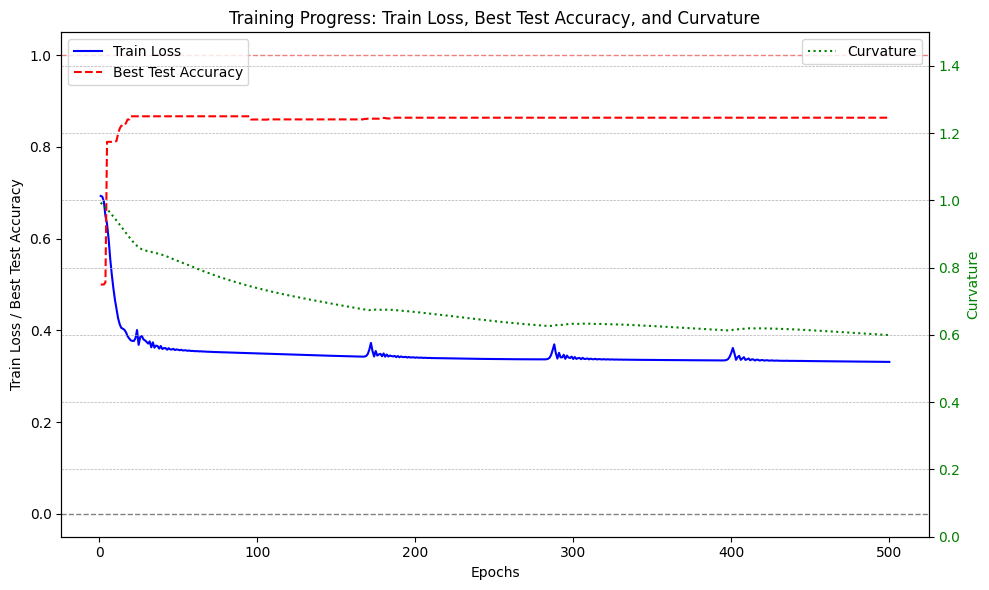

In [17]:
##########################################################
# PLOTTING
##########################################################
import matplotlib.pyplot as plt
epochs = list(range(1, num_epochs + 1))
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training loss and test accuracy on the primary y-axis
ax1.plot(epochs, train_losses, label="Train Loss", color="blue", linestyle="-")
ax1.plot(epochs, test_accuracies, label="Best Test Accuracy", color="red", linestyle="--")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Train Loss / Best Test Accuracy", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.legend(loc="upper left")


# Add a horizontal line at y=1
ax1.axhline(y=1, color="lightcoral", linestyle="--", linewidth=1, label="y=1")

# Add a horizontal line at y=0
ax1.axhline(y=0, color="grey", linestyle="--", linewidth=1, label="y=1")

# Plot curvature on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(epochs, curvatures, label="Curvature", color="green", linestyle=":")
ax2.set_ylabel("Curvature", color="green")
ax2.tick_params(axis="y", labelcolor="green")
ax2.legend(loc="upper right")

# Add title and grid
plt.title("Training Progress: Train Loss, Best Test Accuracy, and Curvature")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def visualize_embeddings_in_poincare(node_emb, labels, manifold, epoch=None):
    """
    Visualizes the node embeddings in the Poincaré disk using t-SNE for dimensionality reduction.
    It maps the hyperbolic embeddings to Euclidean space, reduces them to 2D, and visualizes them.

    Parameters:
    - node_emb: Tensor of node embeddings from the model [num_nodes, hidden_dim]
    - labels: Array of node labels [num_nodes]
    - manifold: The manifold (e.g., PoincaréBall) used for the embeddings
    - epoch: The current epoch (optional, used in title)
    """
    # Map to Euclidean space using logmap
    node_emb_euclidean = manifold.logmap0(node_emb, dim=-1)

    # Reduce to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    node_emb_2d = tsne.fit_transform(node_emb_euclidean.detach().cpu().numpy())

    # Normalize to fit within the unit disk for visualization
    norm = np.linalg.norm(node_emb_2d, axis=1, keepdims=True)
    node_emb_2d = node_emb_2d / norm  # Keep points within the unit disk

    # Plot the embeddings
    plt.figure(figsize=(8, 8))
    plt.scatter(node_emb_2d[:, 0], node_emb_2d[:, 1], c=labels, cmap="viridis", s=30, alpha=0.7)
    plt.colorbar()  # Show color bar to indicate label classes

    # Draw the boundary of the Poincaré disk (unit circle)
    circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--', linewidth=2)
    plt.gca().add_artist(circle)

    # Set plot limits and aspect
    plt.title(f"Node Embeddings in the Poincaré Disk (Epoch {epoch})" if epoch else "Node Embeddings in the Poincaré Disk")
    plt.axis('equal')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

def hyperbolic_to_euclidean(embedding):
    """Project hyperbolic embeddings from the Poincaré disk to Euclidean space."""
    x, y = embedding[:, 0], embedding[:, 1]
    norm = x**2 + y**2
    x_euclidean = 2 * x / (1 + norm)
    y_euclidean = 2 * y / (1 + norm)
    return np.stack([x_euclidean, y_euclidean], axis=1)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def visualize_embeddings_in_batches_no_normalization(node_emb, labels, manifold, batch_size=1024, epoch=None):
    """
    Visualizes the node embeddings in 2D using t-SNE, processing the data in batches.
    It maps the hyperbolic embeddings to Euclidean space, reduces them to 2D, and visualizes them.

    Parameters:
    - node_emb: Tensor of node embeddings from the model [num_nodes, hidden_dim]
    - labels: Array of node labels [num_nodes]
    - manifold: The manifold (e.g., PoincaréBall) used for the embeddings
    - batch_size: The batch size for processing (default is 1024)
    - epoch: The current epoch (optional, used in title)
    """
    # Create lists to store batch results
    batch_node_emb_2d = []
    batch_labels = []

    # Process the embeddings in batches
    num_batches = (len(node_emb) + batch_size - 1) // batch_size  # Calculate the number of batches
    for i in range(num_batches):
        # Select the batch (slice the embeddings and labels)
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(node_emb))

        batch_emb = node_emb[start_idx:end_idx]
        batch_lbl = labels[start_idx:end_idx]

        # Map the embeddings to Euclidean space using logmap
        batch_emb_euclidean = manifold.logmap0(batch_emb, dim=-1)

        # Reduce the embeddings to 2D using t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        batch_emb_2d = tsne.fit_transform(batch_emb_euclidean.detach().cpu().numpy())

        # Skip normalization for now (visualize in original space)
        batch_node_emb_2d.append(batch_emb_2d)
        batch_labels.append(batch_lbl)

    # Concatenate the results from all batches
    node_emb_2d = np.concatenate(batch_node_emb_2d, axis=0)
    labels = np.concatenate(batch_labels, axis=0)

    # Plot the embeddings
    plt.figure(figsize=(8, 8))
    plt.scatter(node_emb_2d[:, 0], node_emb_2d[:, 1], c=labels, cmap="viridis", s=30, alpha=0.7)
    plt.colorbar()  # Show color bar to indicate label classes

    # Set plot limits and aspect
    plt.title(f"Node Embeddings (Epoch {epoch})" if epoch else "Node Embeddings")
    plt.axis('equal')
    plt.show()
